In [1]:
import importlib
import torch
import soundfile as sf
import numpy as np
import nussl
from IPython.display import Audio, display
import torchaudio
import torchaudio.transforms as T
from pathlib import Path
from openunmix.vae import *

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
c:\Users\Murad Hüseynov\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [9]:
audio_folder = 'ground_truth_others'  # Folder containing 'others' audio files
latent_dim = 32
input_dim = 2974  # Adjust input dim to match audio file length after processing
batch_size = 16
num_epochs = 10

In [10]:
print(audio_folder)
dataset = AudioDataset(audio_folder)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

ground_truth_others


In [11]:
sample_audio = next(iter(dataloader))
print(f"Sample audio shape: {sample_audio.shape}")  # Should be (batch_size, target_length)


Sample audio shape: torch.Size([16, 2974])


In [12]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize VAE and move to the appropriate device
vae = VAE(input_dim=2974, latent_dim=64).to(device)

# Apply custom initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

vae.apply(init_weights)


Using device: cpu


VAE(
  (fc1): Linear(in_features=2974, out_features=2379, bias=True)
  (fc2): Linear(in_features=2379, out_features=1788, bias=True)
  (fc3): Linear(in_features=1788, out_features=1192, bias=True)
  (fc4): Linear(in_features=1192, out_features=596, bias=True)
  (fc5): Linear(in_features=596, out_features=128, bias=True)
  (fc6): Linear(in_features=64, out_features=596, bias=True)
  (fc7): Linear(in_features=596, out_features=1192, bias=True)
  (fc8): Linear(in_features=1192, out_features=1788, bias=True)
  (fc9): Linear(in_features=1788, out_features=2379, bias=True)
  (fc10): Linear(in_features=2379, out_features=2974, bias=True)
)

In [13]:
print(vae)

VAE(
  (fc1): Linear(in_features=2974, out_features=2379, bias=True)
  (fc2): Linear(in_features=2379, out_features=1788, bias=True)
  (fc3): Linear(in_features=1788, out_features=1192, bias=True)
  (fc4): Linear(in_features=1192, out_features=596, bias=True)
  (fc5): Linear(in_features=596, out_features=128, bias=True)
  (fc6): Linear(in_features=64, out_features=596, bias=True)
  (fc7): Linear(in_features=596, out_features=1192, bias=True)
  (fc8): Linear(in_features=1192, out_features=1788, bias=True)
  (fc9): Linear(in_features=1788, out_features=2379, bias=True)
  (fc10): Linear(in_features=2379, out_features=2974, bias=True)
)


In [14]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [15]:
import torch
from tqdm import tqdm
import time

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    start_time = time.time()
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    
    for batch_idx, audio in enumerate(progress_bar):
        batch_start_time = time.time()

        print(f"Batch {batch_idx} input shape: {audio.shape}")

        # Ensure the batch tensor matches (batch_size, input_dim)
        assert audio.ndim == 2, f"Expected 2D tensor, got {audio.ndim}D tensor"
        assert audio.shape[1] == input_dim, f"Expected input dimension {input_dim}, got {audio.shape[1]}"

        # Move audio to device
        audio = audio.to(device)

        # Zero gradients, forward pass, compute loss, backprop, and optimize
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(audio)

        if torch.isnan(recon_batch).any():
            print(f"NaN detected in reconstruction at batch {batch_idx}")
        if torch.isnan(mu).any() or torch.isnan(logvar).any():
            print(f"NaN detected in latent variables at batch {batch_idx}")


        # loss = loss_function(recon_batch, audio, mu, logvar)
        # Inside the training loop, replace the loss computation
        recon_loss_weight = 1.0
        kl_loss_weight = 0.1  # Scale KL divergence down initially
        loss = recon_loss_weight * F.mse_loss(recon_batch, audio, reduction='mean') + kl_loss_weight * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / audio.size(0))
        

        if torch.isnan(loss):
            print(f"NaN detected in loss at batch {batch_idx}")

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        # After loss.backward()
        for name, param in vae.named_parameters():
            if param.grad is not None:
                print(f"{name} gradient norm: {torch.norm(param.grad)}")


        optimizer.step()
        train_loss += loss.item()

        # Debugging
        print(f"Reconstructed batch sample: {recon_batch[0, :10]}")
        print(f"Latent mu: {mu[:5]}")
        print(f"Latent logvar: {logvar[:5]}")

        batch_end_time = time.time()
        # Update progress bar
        progress_bar.set_postfix(loss=train_loss / ((batch_idx + 1) * batch_size))
        # Inside the training loop
        print(f"Reconstructed batch sample: {recon_batch[0, :10]}")  # Print the first 10 values


    epoch_end_time = time.time()
    print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_end_time - start_time:.4f} seconds")
    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {train_loss / len(dataloader.dataset)}")

# Save the model after training
torch.save(vae.state_dict(), 'vae_mel_spectrogram.pth')


Using device: cpu


Epoch 1/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.2659764289855957
fc1.bias gradient norm: 0.024100640788674355
fc2.weight gradient norm: 0.30641064047813416
fc2.bias gradient norm: 0.0381249338388443
fc3.weight gradient norm: 0.31868863105773926
fc3.bias gradient norm: 0.0568728931248188
fc4.weight gradient norm: 0.29862189292907715
fc4.bias gradient norm: 0.08072107285261154
fc5.weight gradient norm: 0.18824291229248047
fc5.bias gradient norm: 0.0884992852807045
fc6.weight gradient norm: 0.005522125866264105
fc6.bias gradient norm: 0.0011255708523094654
fc7.weight gradient norm: 0.009990079328417778
fc7.bias gradient norm: 0.0017492887564003468
fc8.weight gradient norm: 0.012459752149879932
fc8.bias gradient norm: 0.0024457580875605345
fc9.weight gradient norm: 0.013402734883129597
fc9.bias gradient norm: 0.003189617535099387
fc10.weight gradient norm: 0.012252778746187687
fc10.bias gradient norm: 0.0035002685617655516


Epoch 1/10:  11%|█         | 1/9 [00:00<00:03,  2.38it/s, loss=0.0109]

Reconstructed batch sample: tensor([-0.1102,  0.0030,  0.0104,  0.0193,  0.1258, -0.0075, -0.0409,  0.0977,
         0.0222,  0.1356], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 0.0268, -0.0881, -0.0272, -0.0996, -0.1754, -0.2200,  0.1595, -0.0530,
          0.0277, -0.0811, -0.1618, -0.0010, -0.0491,  0.0271,  0.0121,  0.0744,
         -0.1381, -0.0908,  0.2171, -0.2258, -0.0255,  0.2099,  0.0485, -0.1307,
          0.0765,  0.2489, -0.2388, -0.2329, -0.0315, -0.0798, -0.1393, -0.0558,
          0.1273, -0.0895, -0.0509,  0.2907, -0.1193,  0.1304, -0.0019,  0.0198,
          0.0270, -0.0431, -0.0346,  0.0498,  0.0668,  0.2751,  0.0170, -0.0916,
         -0.1060,  0.1467, -0.1064, -0.1191,  0.0072,  0.0553,  0.1422,  0.0888,
         -0.1835, -0.0090,  0.0788, -0.2457,  0.2489,  0.2854, -0.1845,  0.0814],
        [ 0.1593, -0.2278, -0.0554,  0.0255,  0.0262, -0.0795,  0.1788, -0.0417,
          0.0275,  0.0334, -0.0711,  0.1100, -0.1438, -0.1581,  0.0640,  0.1596,
         -0.1103,

Epoch 1/10:  11%|█         | 1/9 [00:00<00:03,  2.38it/s, loss=0.0167]

fc1.weight gradient norm: 0.2593238055706024
fc1.bias gradient norm: 0.03509681671857834
fc2.weight gradient norm: 0.38796690106391907
fc2.bias gradient norm: 0.053755246102809906
fc3.weight gradient norm: 0.5252928137779236
fc3.bias gradient norm: 0.07512892782688141
fc4.weight gradient norm: 0.578326404094696
fc4.bias gradient norm: 0.0992799624800682
fc5.weight gradient norm: 0.3744005858898163
fc5.bias gradient norm: 0.10934798419475555
fc6.weight gradient norm: 0.0019921800121665
fc6.bias gradient norm: 0.00036578040453605354
fc7.weight gradient norm: 0.003608844941481948
fc7.bias gradient norm: 0.000597779406234622
fc8.weight gradient norm: 0.00442724023014307
fc8.bias gradient norm: 0.0009750009630806744
fc9.weight gradient norm: 0.004387176129966974
fc9.bias gradient norm: 0.001444352907128632
fc10.weight gradient norm: 0.003648467594757676
fc10.bias gradient norm: 0.0016788977663964033
Reconstructed batch sample: tensor([-0.0663,  0.0002, -0.0264, -0.0471, -0.0221, -0.0392, -0

Epoch 1/10:  22%|██▏       | 2/9 [00:00<00:02,  2.61it/s, loss=0.0167]

Reconstructed batch sample: tensor([-0.0663,  0.0002, -0.0264, -0.0471, -0.0221, -0.0392, -0.0457,  0.0276,
        -0.0445, -0.0687], grad_fn=<SliceBackward0>)
Batch 2 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.10566336661577225
fc1.bias gradient norm: 0.014167801477015018
fc2.weight gradient norm: 0.15475283563137054
fc2.bias gradient norm: 0.02262607403099537
fc3.weight gradient norm: 0.2529754042625427
fc3.bias gradient norm: 0.037662580609321594
fc4.weight gradient norm: 0.304580956697464
fc4.bias gradient norm: 0.061411548405885696
fc5.weight gradient norm: 0.13211508095264435
fc5.bias gradient norm: 0.07716254889965057
fc6.weight gradient norm: 0.002301519736647606
fc6.bias gradient norm: 0.00033786159474402666
fc7.weight gradient norm: 0.003911952022463083
fc7.bias gradient norm: 0.0005763187073171139
fc8.weight gradient norm: 0.004621503874659538
fc8.bias gradient norm: 0.0010558065259829164
fc9.weight gradient norm: 0.005141825415194035
fc9.bias gradient 

Epoch 1/10:  33%|███▎      | 3/9 [00:01<00:02,  2.43it/s, loss=0.0138]

Reconstructed batch sample: tensor([-0.0179, -0.0669, -0.0309, -0.0456, -0.0477, -0.0599, -0.0109, -0.0725,
        -0.0225, -0.0515], grad_fn=<SliceBackward0>)
Batch 3 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.04296083003282547
fc1.bias gradient norm: 0.005095026921480894
fc2.weight gradient norm: 0.06251037120819092
fc2.bias gradient norm: 0.00857040286064148
fc3.weight gradient norm: 0.12473008036613464
fc3.bias gradient norm: 0.01650926098227501
fc4.weight gradient norm: 0.13902530074119568
fc4.bias gradient norm: 0.027340706437826157
fc5.weight gradient norm: 0.04397450387477875
fc5.bias gradient norm: 0.03828538581728935
fc6.weight gradient norm: 0.0013525477843359113
fc6.bias gradient norm: 0.00019533491285983473
fc7.weight gradient norm: 0.002231510588899255
fc7.bias gradient norm: 0.0003195827011950314
fc8.weight gradient norm: 0.0024861989077180624
fc8.bias gradient norm: 0.0005862965481355786
fc9.weight gradient norm: 0.003007636871188879
fc9.bias gradi

Epoch 1/10:  44%|████▍     | 4/9 [00:01<00:02,  2.09it/s, loss=0.0119]

Reconstructed batch sample: tensor([ 0.0076,  0.0018, -0.0035, -0.0020, -0.0488, -0.0430, -0.0013, -0.0046,
        -0.0077, -0.0342], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.9374e-02,  3.6433e-02, -3.7160e-02,  6.2458e-02,  6.2514e-02,
          6.6404e-02,  1.5675e-02, -2.2925e-02,  5.2843e-02,  8.2911e-03,
          5.6720e-02,  1.6764e-03,  2.2539e-02,  5.3043e-02, -2.6913e-02,
         -3.5338e-02,  7.3509e-03,  4.5176e-02,  2.9334e-02,  3.0760e-02,
         -6.7852e-02,  1.5936e-02,  6.9297e-02, -7.0120e-02, -1.8858e-02,
          1.4555e-02, -2.3489e-02, -2.4755e-02,  4.7022e-03, -6.1962e-03,
          9.2758e-03,  4.3923e-02, -7.5981e-02, -1.2854e-02, -1.6849e-03,
         -1.4328e-02,  5.0359e-02,  1.4277e-02,  1.1863e-02, -5.1819e-02,
          7.4608e-02,  3.9088e-02, -5.5429e-02, -5.3559e-02, -3.8351e-02,
          8.4356e-03,  2.6105e-02, -1.9360e-02,  2.0422e-02,  3.4722e-02,
          1.7421e-02, -2.0293e-02, -3.6406e-02, -5.5102e-02,  6.1753e-02,
          9.46

Epoch 1/10:  56%|█████▌    | 5/9 [00:02<00:02,  1.90it/s, loss=0.0108]

Reconstructed batch sample: tensor([ 0.0157, -0.0069, -0.0160,  0.0055, -0.0456, -0.0142, -0.0185,  0.0074,
        -0.0086, -0.0249], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-0.0146,  0.0825, -0.0195, -0.0480, -0.0252, -0.0291, -0.0600,  0.0243,
          0.0323,  0.0811, -0.0144, -0.0812, -0.0380,  0.0091,  0.0269,  0.0259,
          0.0854,  0.0269, -0.0113, -0.0062, -0.1045, -0.0086, -0.0523, -0.0563,
         -0.0296, -0.0258,  0.0855, -0.0362, -0.0241,  0.0488,  0.0240,  0.0134,
         -0.0544,  0.0014, -0.0586, -0.0540, -0.0128, -0.0235,  0.0261, -0.0734,
          0.0460, -0.0549,  0.0150,  0.0831, -0.0684, -0.0166,  0.0494,  0.0345,
          0.0699, -0.0488, -0.0538,  0.0852, -0.0684, -0.0259,  0.0247,  0.1349,
         -0.0071,  0.0483, -0.0134, -0.0032, -0.0816,  0.0004, -0.0040,  0.1040],
        [-0.0258,  0.0572, -0.0049, -0.0446, -0.0260,  0.0145, -0.0365, -0.0005,
          0.0290,  0.0175, -0.0144, -0.0464,  0.0068, -0.0365, -0.0057,  0.0353,
          0.0378,

Epoch 1/10:  67%|██████▋   | 6/9 [00:03<00:01,  1.78it/s, loss=0.00998]

Reconstructed batch sample: tensor([ 0.0177, -0.0011,  0.0064,  0.0083, -0.0156,  0.0095, -0.0116, -0.0090,
         0.0021, -0.0036], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-7.2768e-02,  2.6503e-02,  5.6061e-02, -9.2111e-02, -1.2459e-01,
         -4.5332e-04, -8.3137e-02,  3.8754e-02, -7.8715e-02,  2.5391e-02,
         -2.2952e-02, -2.0200e-02, -1.1951e-02, -5.6744e-02,  5.9747e-03,
         -5.2238e-02,  8.1424e-03,  3.2719e-02, -6.4820e-02, -3.3842e-02,
         -1.1095e-02, -1.7084e-02, -5.4493e-02,  9.1874e-02,  4.8511e-02,
         -5.4605e-02, -6.2754e-02, -1.3914e-02, -4.5275e-02, -8.7558e-04,
          5.8213e-02, -1.1700e-02, -5.5887e-02,  5.4092e-02, -3.4231e-02,
          1.4184e-02,  2.1040e-02, -3.6322e-02,  6.7844e-02, -3.3934e-02,
          8.1645e-03, -6.2147e-02,  5.0434e-02,  2.5424e-02,  2.1813e-02,
          4.9403e-03,  2.8585e-02, -3.4197e-02, -4.4457e-02, -1.4194e-02,
          1.4639e-02,  7.8366e-02,  1.2133e-02, -7.8835e-03,  3.5749e-02,
         -3.31

Epoch 1/10:  78%|███████▊  | 7/9 [00:03<00:01,  1.53it/s, loss=0.00927]

Reconstructed batch sample: tensor([ 0.0203,  0.0068,  0.0092,  0.0178, -0.0107,  0.0021, -0.0018,  0.0112,
         0.0047, -0.0104], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 0.0181,  0.0274, -0.0155,  0.0118, -0.0258,  0.0130,  0.0130,  0.0461,
          0.0158,  0.0257,  0.0224, -0.0166, -0.0219, -0.0134, -0.0134,  0.0014,
         -0.0036, -0.0047, -0.0181,  0.0460, -0.0138,  0.0163, -0.0186,  0.0464,
         -0.0204, -0.0155, -0.0234,  0.0050, -0.0269, -0.0232,  0.0165,  0.0031,
         -0.0063, -0.0014, -0.0115, -0.0259,  0.0130,  0.0229, -0.0173, -0.0150,
          0.0252, -0.0227, -0.0064, -0.0241,  0.0164,  0.0063, -0.0041, -0.0129,
          0.0142,  0.0071, -0.0051,  0.0295, -0.0261,  0.0221,  0.0034, -0.0084,
         -0.0123, -0.0029,  0.0369, -0.0221,  0.0230,  0.0030, -0.0180, -0.0366],
        [-0.0082,  0.0268, -0.0014,  0.0023, -0.0296,  0.0256,  0.0250,  0.0315,
          0.0209,  0.0067,  0.0264, -0.0216, -0.0222,  0.0009, -0.0055,  0.0223,
         -0.0150,

Epoch 1/10:  89%|████████▉ | 8/9 [00:04<00:00,  1.48it/s, loss=0.00882]

Reconstructed batch sample: tensor([ 0.0046, -0.0019,  0.0272,  0.0077, -0.0050, -0.0105, -0.0092,  0.0034,
        -0.0013, -0.0074], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.6164e-02,  9.4259e-03, -1.4819e-02,  1.9902e-02,  3.5449e-03,
         -9.7750e-03,  2.2187e-03, -1.1248e-02,  1.8366e-02,  2.3549e-02,
          4.9524e-03, -9.4444e-03, -1.7632e-03, -6.3562e-03,  3.6606e-03,
          6.5289e-03, -1.9686e-02, -1.2295e-03, -1.3681e-02,  2.1521e-02,
          5.9954e-03,  3.0376e-02, -7.1499e-03,  8.5672e-03, -9.2846e-03,
         -6.4862e-03,  1.2821e-02,  1.3548e-02,  2.1864e-02, -2.7496e-02,
          5.6952e-04,  2.9805e-02,  1.8683e-02,  6.9675e-03,  1.1477e-02,
         -1.9354e-02,  2.2644e-02,  4.1088e-02, -2.0140e-02, -2.0296e-02,
          1.4285e-02,  1.6244e-02, -6.7296e-04, -2.5628e-02, -1.9053e-03,
          1.1315e-02, -2.3816e-02,  2.0560e-02, -3.2132e-03,  4.4873e-02,
         -2.1532e-02,  1.4162e-02,  1.4981e-03,  1.1371e-02, -4.1696e-03,
         -2.75

Reconstructed batch sample: tensor([ 0.0018, -0.0012,  0.0118, -0.0017, -0.0024, -0.0055,  0.0031,  0.0089,
         0.0190, -0.0039], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-7.6461e-03,  3.9431e-03, -1.4492e-02, -6.3297e-03,  9.0860e-03,
         -2.8997e-03, -2.0406e-02, -2.2035e-02, -3.3012e-02,  1.1591e-02,
         -7.3596e-03, -1.3824e-02, -9.7788e-03,  3.7011e-03,  1.3114e-02,
         -6.1639e-03, -9.4794e-03, -1.4347e-02, -2.3412e-02,  2.3151e-02,
          2.6893e-02, -3.3494e-03, -9.5769e-04, -1.1738e-02,  2.1193e-02,
          2.0613e-02,  1.3345e-02, -1.7411e-02,  1.7722e-02,  2.0417e-03,
         -2.5649e-02,  1.5248e-02,  1.5699e-02, -3.3571e-03,  9.8536e-03,
         -8.0388e-03,  3.5208e-04,  8.4486e-03,  7.2311e-03, -2.0449e-02,
          1.5502e-02,  2.7435e-02,  2.1424e-02, -9.2788e-03, -4.9786e-04,
         -2.4730e-03,  1.0134e-02,  1.5361e-02, -3.2416e-02, -4.8434e-03,
         -2.5592e-02,  4.3178e-04,  3.5720e-02, -2.2019e-03,  5.0030e-03,
         -2.40

Epoch 2/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0036121078301221132
fc1.bias gradient norm: 0.000263340916717425
fc2.weight gradient norm: 0.005543374456465244
fc2.bias gradient norm: 0.00044269990758039057
fc3.weight gradient norm: 0.014469502493739128
fc3.bias gradient norm: 0.0010269415797665715
fc4.weight gradient norm: 0.023020969703793526
fc4.bias gradient norm: 0.002583095571026206
fc5.weight gradient norm: 0.0010827237274497747
fc5.bias gradient norm: 0.005324855446815491
fc6.weight gradient norm: 0.0007561617530882359
fc6.bias gradient norm: 9.35562202357687e-05
fc7.weight gradient norm: 0.0012582585914060473
fc7.bias gradient norm: 0.00016500147467013448
fc8.weight gradient norm: 0.001403057249262929
fc8.bias gradient norm: 0.0003827360924333334
fc9.weight gradient norm: 0.0017324447399005294
fc9.bias gradient norm: 0.0009995772270485759
fc10.weight gradient norm: 0.001026581390760839
fc10.bias gradient norm: 0.002775847679004073


Epoch 2/10:  11%|█         | 1/9 [00:00<00:04,  1.68it/s, loss=0.00596]

Reconstructed batch sample: tensor([ 0.0156,  0.0004,  0.0100,  0.0040, -0.0053, -0.0006, -0.0063,  0.0020,
         0.0066, -0.0021], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 5.0066e-03,  8.4996e-04, -1.7574e-03, -2.7912e-03,  3.2980e-03,
          4.3492e-03, -7.5498e-03, -4.3669e-03, -3.3881e-03, -8.4270e-03,
         -2.2918e-04, -6.8248e-03,  6.5974e-03,  3.4737e-03,  4.6354e-03,
         -2.7026e-03, -1.6406e-03,  7.1214e-03,  2.1120e-03,  6.8519e-03,
          2.6964e-03, -2.7576e-03,  2.8402e-04, -3.5021e-03, -4.7799e-03,
          4.9331e-03,  4.2363e-03, -1.1712e-03, -2.7047e-03, -8.9843e-03,
         -4.4284e-03,  3.2028e-03,  2.2157e-03, -4.2621e-03, -2.7131e-03,
         -2.7215e-03,  1.1400e-03, -5.0290e-03, -2.7732e-03,  8.2834e-04,
          1.3363e-03, -3.2737e-04, -2.9151e-03, -8.7206e-04,  4.7700e-04,
         -8.3388e-04, -5.0696e-03,  1.4426e-03, -2.0534e-03, -2.5602e-03,
         -3.2113e-03, -1.3759e-03, -5.7379e-03, -7.5530e-03, -5.9589e-03,
          5.13

Epoch 2/10:  22%|██▏       | 2/9 [00:01<00:04,  1.68it/s, loss=0.00593]

Reconstructed batch sample: tensor([ 0.0018, -0.0049,  0.0015, -0.0075, -0.0130,  0.0014, -0.0017,  0.0029,
        -0.0003, -0.0064], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-6.0521e-04, -2.2086e-03, -1.4189e-03, -2.1658e-03,  6.2932e-04,
         -1.5507e-04, -9.1615e-04,  2.3028e-03, -2.7253e-03, -2.7947e-03,
         -2.0050e-03, -4.7913e-03,  1.0773e-03,  2.4562e-03,  4.8856e-03,
         -1.7021e-03,  5.2577e-04,  4.2034e-03,  7.7162e-04,  1.2955e-03,
         -1.2041e-04, -4.7008e-03, -1.2738e-03,  1.9682e-03, -3.6605e-04,
         -2.6119e-03,  2.6692e-03, -1.4838e-03, -8.3990e-04, -2.2468e-03,
         -9.7305e-04,  1.5646e-03, -1.5372e-03,  5.8000e-04, -1.5240e-03,
          3.4840e-05,  8.6188e-04, -1.3923e-03,  4.4917e-03, -1.8737e-03,
          4.2200e-04, -4.4993e-03,  1.7427e-03,  8.4906e-04, -3.5942e-03,
          3.4052e-03, -1.5343e-03,  2.6440e-03,  2.2527e-03, -2.6682e-03,
          3.0827e-04,  1.9327e-03,  1.0406e-03, -4.9565e-03,  1.3032e-03,
         -3.14

Epoch 2/10:  33%|███▎      | 3/9 [00:01<00:03,  1.63it/s, loss=0.0057] 

Reconstructed batch sample: tensor([-5.0068e-05, -1.2210e-03,  2.2999e-03, -1.8040e-02, -1.6665e-02,
        -6.2109e-03, -7.0074e-03,  1.4103e-02, -4.6820e-03, -8.4769e-03],
       grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.4784e-04, -1.9057e-03, -2.5130e-03, -3.5728e-03, -1.0707e-03,
          1.7763e-03, -6.2133e-04, -1.3528e-03, -9.7239e-04, -4.3047e-03,
          7.4002e-04, -3.8461e-03,  5.4697e-04,  2.1619e-03,  1.7633e-03,
          7.0960e-04, -1.5325e-04,  2.7626e-03,  2.1412e-03,  1.9456e-03,
         -2.5226e-03, -2.7617e-04, -3.4467e-03,  2.1743e-03, -1.0809e-03,
          3.3055e-04,  1.8723e-03, -1.1978e-03, -8.2925e-04, -2.1640e-03,
         -2.6237e-03,  2.5173e-03, -4.2106e-04,  9.2593e-04, -1.0091e-03,
         -7.4019e-04, -2.9708e-04,  2.1853e-03,  2.3913e-03,  7.1748e-04,
         -1.3291e-04, -3.0149e-03,  5.2021e-04, -1.3449e-03, -6.2915e-04,
          1.1780e-03, -4.0508e-03,  3.1300e-03,  1.5546e-03, -8.4082e-04,
          9.1120e-04,  1.4968e-03,  2.368

Epoch 2/10:  44%|████▍     | 4/9 [00:02<00:03,  1.64it/s, loss=0.00557]

Reconstructed batch sample: tensor([ 0.0136,  0.0054, -0.0013, -0.0223, -0.0167, -0.0087,  0.0005,  0.0037,
         0.0041, -0.0157], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.1708e-04, -2.2346e-03, -2.5687e-03, -3.6888e-03, -1.1626e-03,
          1.6645e-03, -3.8444e-04, -1.2184e-03, -1.0020e-03, -4.5220e-03,
          4.7430e-04, -3.8901e-03,  8.0952e-04,  2.0368e-03,  1.8540e-03,
          4.4675e-04, -1.8343e-04,  2.8473e-03,  2.7070e-03,  1.7205e-03,
         -2.8901e-03, -4.8966e-04, -3.4536e-03,  2.4694e-03, -1.3149e-03,
          3.3937e-04,  1.8208e-03, -1.2775e-03, -7.7727e-04, -2.1802e-03,
         -2.3675e-03,  2.2012e-03, -5.3983e-04,  8.1401e-04, -1.3900e-03,
         -4.7193e-04, -1.2022e-04,  2.4718e-03,  2.4694e-03,  1.4038e-03,
         -1.5804e-04, -2.7831e-03,  5.1560e-04, -1.0994e-03, -3.7088e-04,
          9.7444e-04, -4.0716e-03,  2.7743e-03,  1.8961e-03, -6.4676e-04,
          9.6085e-04,  1.2037e-03,  2.4548e-03, -1.3551e-03, -5.8053e-04,
         -5.84

Epoch 2/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.63it/s, loss=0.00549]

Reconstructed batch sample: tensor([ 0.0172,  0.0095,  0.0035, -0.0120, -0.0059, -0.0035,  0.0138,  0.0111,
         0.0121, -0.0009], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 0.0003, -0.0026, -0.0024, -0.0039, -0.0010,  0.0013, -0.0002, -0.0013,
         -0.0009, -0.0047,  0.0003, -0.0037,  0.0009,  0.0023,  0.0019,  0.0006,
         -0.0002,  0.0028,  0.0028,  0.0016, -0.0027, -0.0003, -0.0034,  0.0024,
         -0.0013,  0.0005,  0.0017, -0.0015, -0.0010, -0.0022, -0.0026,  0.0022,
         -0.0004,  0.0009, -0.0014, -0.0004, -0.0004,  0.0026,  0.0025,  0.0017,
         -0.0003, -0.0029,  0.0004, -0.0012, -0.0005,  0.0011, -0.0043,  0.0028,
          0.0020, -0.0005,  0.0011,  0.0013,  0.0026, -0.0013, -0.0006, -0.0006,
         -0.0006,  0.0021, -0.0013,  0.0026, -0.0004, -0.0011,  0.0005,  0.0023],
        [ 0.0003, -0.0026, -0.0024, -0.0039, -0.0010,  0.0013, -0.0002, -0.0013,
         -0.0009, -0.0047,  0.0003, -0.0037,  0.0009,  0.0023,  0.0019,  0.0006,
         -0.0002,

Epoch 2/10:  67%|██████▋   | 6/9 [00:03<00:02,  1.48it/s, loss=0.00564]

Reconstructed batch sample: tensor([ 0.0166,  0.0066,  0.0097, -0.0107, -0.0027,  0.0023,  0.0053,  0.0191,
         0.0085, -0.0023], grad_fn=<SliceBackward0>)
Batch 6 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 7.575967902084813e-05
fc1.bias gradient norm: 4.8812394197739195e-06
fc2.weight gradient norm: 0.00010810288949869573
fc2.bias gradient norm: 7.924776582513005e-06
fc3.weight gradient norm: 0.0002986173494718969
fc3.bias gradient norm: 1.991539102164097e-05
fc4.weight gradient norm: 0.00047839985927566886
fc4.bias gradient norm: 4.524715768638998e-05
fc5.weight gradient norm: 3.1542406304652104e-06
fc5.bias gradient norm: 0.0020337807945907116
fc6.weight gradient norm: 0.0008039389504119754
fc6.bias gradient norm: 0.00010111889423569664
fc7.weight gradient norm: 0.0012528395745903254
fc7.bias gradient norm: 0.00016646148287691176
fc8.weight gradient norm: 0.0015153475105762482
fc8.bias gradient norm: 0.0003976859152317047
fc9.weight gradient norm: 0.001945542

Epoch 2/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.45it/s, loss=0.00558]

Reconstructed batch sample: tensor([ 0.0175,  0.0048,  0.0067, -0.0140, -0.0124,  0.0009,  0.0107,  0.0263,
         0.0020, -0.0028], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.4429e-04, -2.9264e-03, -2.4261e-03, -4.1258e-03, -1.1834e-03,
          1.1086e-03,  7.5563e-05, -1.3987e-03, -9.1715e-04, -5.1504e-03,
          1.6411e-04, -3.5013e-03,  9.3909e-04,  2.3513e-03,  2.2123e-03,
          8.0125e-04, -2.3993e-04,  2.7206e-03,  3.0691e-03,  1.3266e-03,
         -2.6120e-03, -2.3500e-04, -3.4170e-03,  2.3518e-03, -1.5245e-03,
          6.0394e-04,  1.7072e-03, -1.6606e-03, -9.6231e-04, -2.1827e-03,
         -2.6946e-03,  2.1363e-03, -1.8531e-04,  8.9527e-04, -1.5502e-03,
         -3.5630e-04, -5.3444e-04,  2.8329e-03,  2.6966e-03,  2.2756e-03,
         -3.8290e-04, -2.6641e-03,  4.1428e-04, -1.0489e-03, -4.6185e-04,
          1.2127e-03, -4.4335e-03,  2.6653e-03,  2.2302e-03, -5.1717e-04,
          1.1918e-03,  1.2540e-03,  2.5828e-03, -1.1074e-03, -6.7692e-04,
         -5.80

Epoch 2/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.51it/s, loss=0.00562]

Reconstructed batch sample: tensor([ 0.0049,  0.0079,  0.0028, -0.0151, -0.0195, -0.0033, -0.0038,  0.0042,
        -0.0012,  0.0058], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 5.6018e-04, -3.0221e-03, -2.4694e-03, -4.1876e-03, -1.1753e-03,
          9.8306e-04,  1.2231e-04, -1.4406e-03, -8.8982e-04, -5.2705e-03,
          5.6068e-05, -3.4359e-03,  9.7616e-04,  2.3300e-03,  2.2919e-03,
          8.1722e-04, -2.9739e-04,  2.6891e-03,  3.2247e-03,  1.2382e-03,
         -2.5740e-03, -1.5438e-04, -3.3195e-03,  2.3356e-03, -1.5737e-03,
          6.7253e-04,  1.7153e-03, -1.7410e-03, -1.0166e-03, -2.1262e-03,
         -2.7641e-03,  2.1266e-03, -4.9015e-05,  9.4277e-04, -1.5733e-03,
         -3.2284e-04, -5.6674e-04,  2.9192e-03,  2.7120e-03,  2.5590e-03,
         -4.5276e-04, -2.5622e-03,  3.6936e-04, -9.9120e-04, -4.2140e-04,
          1.2256e-03, -4.4726e-03,  2.6182e-03,  2.3091e-03, -4.5494e-04,
          1.1771e-03,  1.2184e-03,  2.5248e-03, -1.0228e-03, -6.9737e-04,
         -6.15

Reconstructed batch sample: tensor([ 0.0141,  0.0007,  0.0011, -0.0032, -0.0086,  0.0021,  0.0068,  0.0197,
         0.0073,  0.0047], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-3.7039e-03,  2.4472e-03, -9.5344e-05, -1.5472e-03,  4.3551e-03,
          5.4401e-03,  3.5814e-03, -8.5769e-04, -5.8806e-03, -6.6814e-03,
         -1.9901e-04, -2.3664e-03,  1.3075e-03,  1.7200e-04,  5.7948e-03,
          3.9300e-03,  2.4485e-03,  8.4595e-04,  5.2051e-03,  2.7258e-03,
         -3.1993e-03,  4.1829e-04, -8.8450e-03, -3.3893e-04, -3.3709e-03,
          6.5591e-04,  5.6638e-03, -3.7544e-03,  3.4728e-03,  2.7778e-03,
         -4.1620e-03,  5.5364e-03, -1.4254e-03,  1.4777e-03, -1.6687e-03,
         -6.8933e-04, -3.2401e-03,  3.8100e-04,  6.3462e-04,  2.8046e-03,
          4.1063e-03,  1.0378e-03,  5.3736e-03, -5.7592e-03, -4.3936e-03,
          5.1961e-03, -8.8225e-03, -1.8620e-03,  4.8325e-03, -4.4908e-03,
         -4.6385e-04,  2.2114e-03,  1.4128e-03, -5.6487e-03,  5.6232e-04,
         -3.79

Epoch 3/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 3.252154783695005e-05
fc1.bias gradient norm: 2.0823181330342777e-06
fc2.weight gradient norm: 7.699966226937249e-05
fc2.bias gradient norm: 3.0972121294325916e-06
fc3.weight gradient norm: 0.00019585329573601484
fc3.bias gradient norm: 7.23570519767236e-06
fc4.weight gradient norm: 0.0003301248943898827
fc4.bias gradient norm: 1.6190724636544473e-05
fc5.weight gradient norm: 1.4434082231673528e-06
fc5.bias gradient norm: 0.002059015678241849
fc6.weight gradient norm: 0.0008241207106038928
fc6.bias gradient norm: 0.00010585964628262445
fc7.weight gradient norm: 0.0012315674684941769
fc7.bias gradient norm: 0.0001581651158630848
fc8.weight gradient norm: 0.0014236379647627473
fc8.bias gradient norm: 0.00040444621117785573
fc9.weight gradient norm: 0.0016741208964958787
fc9.bias gradient norm: 0.00102565239649266
fc10.weight gradient norm: 0.0013237249804660678
fc10.bias gradient norm: 0.002854545833542943


Epoch 3/10:  11%|█         | 1/9 [00:00<00:04,  1.74it/s, loss=0.00615]

Reconstructed batch sample: tensor([ 0.0125,  0.0109,  0.0024,  0.0020, -0.0046, -0.0058,  0.0090,  0.0173,
         0.0005,  0.0084], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 7.1758e-04, -3.2149e-03, -2.4485e-03, -4.2952e-03, -1.2329e-03,
          7.5964e-04,  2.6159e-04, -1.5037e-03, -8.6497e-04, -5.4060e-03,
         -7.2021e-05, -3.2576e-03,  1.0249e-03,  2.3153e-03,  2.4434e-03,
          9.0729e-04, -3.6701e-04,  2.5558e-03,  3.4209e-03,  1.0350e-03,
         -2.4426e-03, -9.8044e-05, -3.1822e-03,  2.2562e-03, -1.6677e-03,
          7.7141e-04,  1.7106e-03, -1.8416e-03, -1.0281e-03, -2.0366e-03,
         -2.7621e-03,  2.0535e-03,  1.3570e-04,  9.6664e-04, -1.6777e-03,
         -2.8027e-04, -6.5297e-04,  3.0777e-03,  2.7539e-03,  2.9752e-03,
         -5.4481e-04, -2.3574e-03,  3.5674e-04, -8.7001e-04, -3.9624e-04,
          1.2790e-03, -4.5128e-03,  2.4561e-03,  2.4261e-03, -4.0642e-04,
          1.1927e-03,  1.1555e-03,  2.4398e-03, -8.7994e-04, -7.1836e-04,
         -5.97

Epoch 3/10:  22%|██▏       | 2/9 [00:01<00:04,  1.66it/s, loss=0.00589]

Reconstructed batch sample: tensor([ 0.0186,  0.0065,  0.0002, -0.0056, -0.0111, -0.0120,  0.0082,  0.0172,
         0.0069,  0.0028], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 7.8381e-04, -3.2859e-03, -2.4252e-03, -4.3229e-03, -1.2545e-03,
          6.5423e-04,  3.1830e-04, -1.5260e-03, -8.4937e-04, -5.4210e-03,
         -1.2801e-04, -3.1623e-03,  1.0422e-03,  2.2947e-03,  2.4978e-03,
          9.4377e-04, -3.9684e-04,  2.4819e-03,  3.4936e-03,  9.4147e-04,
         -2.3667e-03, -7.3336e-05, -3.0999e-03,  2.2081e-03, -1.7009e-03,
          8.1301e-04,  1.7031e-03, -1.8812e-03, -1.0273e-03, -1.9868e-03,
         -2.7382e-03,  2.0148e-03,  2.1499e-04,  9.7401e-04, -1.7188e-03,
         -2.6069e-04, -6.8780e-04,  3.1375e-03,  2.7582e-03,  3.1333e-03,
         -5.8210e-04, -2.2521e-03,  3.4962e-04, -8.1374e-04, -3.8457e-04,
          1.2969e-03, -4.5127e-03,  2.3627e-03,  2.4620e-03, -3.8298e-04,
          1.1953e-03,  1.1244e-03,  2.3895e-03, -8.1334e-04, -7.2475e-04,
         -5.88

Epoch 3/10:  33%|███▎      | 3/9 [00:01<00:03,  1.69it/s, loss=0.00591]

Reconstructed batch sample: tensor([ 0.0092,  0.0011,  0.0082, -0.0122, -0.0163, -0.0124,  0.0024,  0.0045,
        -0.0022, -0.0033], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.4178e-04, -3.3415e-03, -2.3936e-03, -4.3345e-03, -1.2722e-03,
          5.5461e-04,  3.6894e-04, -1.5430e-03, -8.3216e-04, -5.4039e-03,
         -1.7866e-04, -3.0637e-03,  1.0554e-03,  2.2650e-03,  2.5394e-03,
          9.7544e-04, -4.2330e-04,  2.4034e-03,  3.5514e-03,  8.5291e-04,
         -2.2844e-03, -5.0749e-05, -3.0111e-03,  2.1546e-03, -1.7262e-03,
          8.4972e-04,  1.6924e-03, -1.9146e-03, -1.0228e-03, -1.9342e-03,
         -2.7012e-03,  1.9749e-03,  2.8537e-04,  9.7819e-04, -1.7532e-03,
         -2.4219e-04, -7.1708e-04,  3.1857e-03,  2.7523e-03,  3.2601e-03,
         -6.1309e-04, -2.1454e-03,  3.4240e-04, -7.6038e-04, -3.7351e-04,
          1.3099e-03, -4.5013e-03,  2.2623e-03,  2.4848e-03, -3.6053e-04,
          1.1946e-03,  1.0937e-03,  2.3347e-03, -7.5019e-04, -7.2894e-04,
         -5.79

Epoch 3/10:  44%|████▍     | 4/9 [00:02<00:02,  1.74it/s, loss=0.00577]

Reconstructed batch sample: tensor([ 0.0003, -0.0042,  0.0013, -0.0093, -0.0046, -0.0127,  0.0032,  0.0026,
         0.0102,  0.0073], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.9203e-04, -3.3831e-03, -2.3546e-03, -4.3315e-03, -1.2857e-03,
          4.6090e-04,  4.1254e-04, -1.5553e-03, -8.1359e-04, -5.3575e-03,
         -2.2408e-04, -2.9626e-03,  1.0651e-03,  2.2272e-03,  2.5692e-03,
          1.0026e-03, -4.4651e-04,  2.3213e-03,  3.5954e-03,  7.6891e-04,
         -2.1970e-03, -2.9903e-05, -2.9162e-03,  2.0963e-03, -1.7442e-03,
          8.8195e-04,  1.6790e-03, -1.9423e-03, -1.0145e-03, -1.8789e-03,
         -2.6530e-03,  1.9337e-03,  3.4787e-04,  9.7949e-04, -1.7814e-03,
         -2.2475e-04, -7.4168e-04,  3.2231e-03,  2.7370e-03,  3.3575e-03,
         -6.3857e-04, -2.0378e-03,  3.3505e-04, -7.0974e-04, -3.6292e-04,
          1.3185e-03, -4.4791e-03,  2.1566e-03,  2.4954e-03, -3.3904e-04,
          1.1909e-03,  1.0635e-03,  2.2760e-03, -6.9067e-04, -7.3113e-04,
         -5.70

Epoch 3/10:  56%|█████▌    | 5/9 [00:02<00:02,  1.74it/s, loss=0.00572]

Reconstructed batch sample: tensor([-8.2717e-03,  6.3045e-03, -1.4895e-03, -1.2225e-02, -1.1404e-02,
        -1.7216e-02,  8.3744e-03, -1.4414e-05,  5.8361e-03,  3.8227e-03],
       grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.3462e-04, -3.4115e-03, -2.3093e-03, -4.3147e-03, -1.2957e-03,
          3.7387e-04,  4.5011e-04, -1.5630e-03, -7.9374e-04, -5.2841e-03,
         -2.6482e-04, -2.8592e-03,  1.0712e-03,  2.1823e-03,  2.5882e-03,
          1.0256e-03, -4.6657e-04,  2.2364e-03,  3.6270e-03,  6.8915e-04,
         -2.1050e-03, -1.0985e-05, -2.8161e-03,  2.0338e-03, -1.7555e-03,
          9.1001e-04,  1.6630e-03, -1.9646e-03, -1.0025e-03, -1.8214e-03,
         -2.5945e-03,  1.8916e-03,  4.0320e-04,  9.7784e-04, -1.8038e-03,
         -2.0841e-04, -7.6161e-04,  3.2509e-03,  2.7134e-03,  3.4278e-03,
         -6.5856e-04, -1.9301e-03,  3.2775e-04, -6.6175e-04, -3.5291e-04,
          1.3232e-03, -4.4469e-03,  2.0454e-03,  2.4950e-03, -3.1859e-04,
          1.1845e-03,  1.0335e-03,  2.214

Epoch 3/10:  67%|██████▋   | 6/9 [00:03<00:01,  1.58it/s, loss=0.00566]

Reconstructed batch sample: tensor([-4.6908e-03, -9.4964e-03,  5.6278e-05, -2.4572e-02, -1.7117e-02,
        -2.8387e-02,  5.7037e-03, -8.9509e-04,  1.8904e-03, -1.0251e-02],
       grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.7024e-04, -3.4278e-03, -2.2583e-03, -4.2857e-03, -1.3025e-03,
          2.9265e-04,  4.8147e-04, -1.5666e-03, -7.7263e-04, -5.1873e-03,
         -3.0101e-04, -2.7537e-03,  1.0739e-03,  2.1308e-03,  2.5976e-03,
          1.0447e-03, -4.8405e-04,  2.1487e-03,  3.6471e-03,  6.1341e-04,
         -2.0092e-03,  6.1415e-06, -2.7115e-03,  1.9670e-03, -1.7603e-03,
          9.3429e-04,  1.6445e-03, -1.9822e-03, -9.8705e-04, -1.7615e-03,
         -2.5270e-03,  1.8481e-03,  4.5144e-04,  9.7317e-04, -1.8211e-03,
         -1.9317e-04, -7.7708e-04,  3.2695e-03,  2.6821e-03,  3.4723e-03,
         -6.7378e-04, -1.8223e-03,  3.2042e-04, -6.1630e-04, -3.4300e-04,
          1.3243e-03, -4.4057e-03,  1.9295e-03,  2.4845e-03, -2.9902e-04,
          1.1753e-03,  1.0042e-03,  2.148

Epoch 3/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.53it/s, loss=0.00567]

Reconstructed batch sample: tensor([-0.0037,  0.0011,  0.0069, -0.0144, -0.0119, -0.0216, -0.0001,  0.0052,
         0.0159, -0.0015], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.9963e-04, -3.4329e-03, -2.2019e-03, -4.2454e-03, -1.3062e-03,
          2.1748e-04,  5.0679e-04, -1.5663e-03, -7.5053e-04, -5.0698e-03,
         -3.3309e-04, -2.6469e-03,  1.0734e-03,  2.0740e-03,  2.5978e-03,
          1.0603e-03, -4.9899e-04,  2.0589e-03,  3.6563e-03,  5.4193e-04,
         -1.9102e-03,  2.1839e-05, -2.6028e-03,  1.8974e-03, -1.7595e-03,
          9.5483e-04,  1.6239e-03, -1.9952e-03, -9.6884e-04, -1.6998e-03,
         -2.4509e-03,  1.8036e-03,  4.9334e-04,  9.6603e-04, -1.8335e-03,
         -1.7876e-04, -7.8859e-04,  3.2794e-03,  2.6441e-03,  3.4940e-03,
         -6.8471e-04, -1.7150e-03,  3.1316e-04, -5.7302e-04, -3.3347e-04,
          1.3220e-03, -4.3564e-03,  1.8098e-03,  2.4646e-03, -2.7990e-04,
          1.1636e-03,  9.7515e-04,  2.0804e-03, -5.2903e-04, -7.2764e-04,
         -5.41

Epoch 3/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.51it/s, loss=0.00567]

Reconstructed batch sample: tensor([ 0.0053,  0.0080,  0.0058, -0.0055, -0.0176, -0.0091,  0.0095,  0.0106,
         0.0084,  0.0212], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0228e-03, -3.4273e-03, -2.1408e-03, -4.1942e-03, -1.3071e-03,
          1.4746e-04,  5.2708e-04, -1.5624e-03, -7.2748e-04, -4.9326e-03,
         -3.6089e-04, -2.5392e-03,  1.0703e-03,  2.0117e-03,  2.5891e-03,
          1.0725e-03, -5.1159e-04,  1.9677e-03,  3.6557e-03,  4.7448e-04,
         -1.8085e-03,  3.6099e-05, -2.4909e-03,  1.8256e-03, -1.7534e-03,
          9.7209e-04,  1.6012e-03, -2.0041e-03, -9.4806e-04, -1.6370e-03,
         -2.3680e-03,  1.7584e-03,  5.2871e-04,  9.5667e-04, -1.8414e-03,
         -1.6533e-04, -7.9624e-04,  3.2816e-03,  2.5997e-03,  3.4936e-03,
         -6.9131e-04, -1.6085e-03,  3.0594e-04, -5.3212e-04, -3.2426e-04,
          1.3163e-03, -4.2994e-03,  1.6881e-03,  2.4360e-03, -2.6116e-04,
          1.1497e-03,  9.4650e-04,  2.0101e-03, -4.8061e-04, -7.2356e-04,
         -5.31

Reconstructed batch sample: tensor([ 0.0037, -0.0006,  0.0025, -0.0045, -0.0052, -0.0134,  0.0060,  0.0040,
         0.0115,  0.0047], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0404e-03, -3.4123e-03, -2.0759e-03, -4.1334e-03, -1.3050e-03,
          8.2195e-05,  5.4230e-04, -1.5550e-03, -7.0350e-04, -4.7787e-03,
         -3.8519e-04, -2.4308e-03,  1.0645e-03,  1.9449e-03,  2.5728e-03,
          1.0817e-03, -5.2216e-04,  1.8757e-03,  3.6460e-03,  4.1093e-04,
         -1.7048e-03,  4.8902e-05, -2.3768e-03,  1.7514e-03, -1.7424e-03,
          9.8619e-04,  1.5766e-03, -2.0091e-03, -9.2532e-04, -1.5733e-03,
         -2.2781e-03,  1.7126e-03,  5.5780e-04,  9.4518e-04, -1.8454e-03,
         -1.5274e-04, -8.0060e-04,  3.2766e-03,  2.5493e-03,  3.4732e-03,
         -6.9402e-04, -1.5037e-03,  2.9864e-04, -4.9341e-04, -3.1532e-04,
          1.3077e-03, -4.2357e-03,  1.5653e-03,  2.3996e-03, -2.4328e-04,
          1.1341e-03,  9.1833e-04,  1.9373e-03, -4.3487e-04, -7.1828e-04,
         -5.21

Epoch 4/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.0018388255266472697
fc6.weight gradient norm: 0.0008803330711089075
fc6.bias gradient norm: 9.507986396783963e-05
fc7.weight gradient norm: 0.0012196190655231476
fc7.bias gradient norm: 0.0001426011003786698
fc8.weight gradient norm: 0.0012504239566624165
fc8.bias gradient norm: 0.0003633142332546413
fc9.weight gradient norm: 0.0013958907220512629
fc9.bias gradient norm: 0.0009229662828147411
fc10.weight gradient norm: 0.0013144598342478275
fc10.bias gradient norm: 0.0025978467892855406


Epoch 4/10:  11%|█         | 1/9 [00:00<00:04,  1.74it/s, loss=0.00579]

Reconstructed batch sample: tensor([ 0.0026,  0.0035,  0.0033, -0.0037, -0.0205, -0.0219,  0.0058,  0.0099,
         0.0191,  0.0100], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0531e-03, -3.3887e-03, -2.0073e-03, -4.0638e-03, -1.3006e-03,
          2.1945e-05,  5.5340e-04, -1.5447e-03, -6.7926e-04, -4.6092e-03,
         -4.0643e-04, -2.3219e-03,  1.0564e-03,  1.8743e-03,  2.5487e-03,
          1.0882e-03, -5.3055e-04,  1.7828e-03,  3.6279e-03,  3.5088e-04,
         -1.5999e-03,  6.0585e-05, -2.2610e-03,  1.6758e-03, -1.7270e-03,
          9.9748e-04,  1.5506e-03, -2.0105e-03, -9.0149e-04, -1.5087e-03,
         -2.1834e-03,  1.6662e-03,  5.8123e-04,  9.3182e-04, -1.8452e-03,
         -1.4079e-04, -8.0197e-04,  3.2648e-03,  2.4942e-03,  3.4342e-03,
         -6.9325e-04, -1.4005e-03,  2.9126e-04, -4.5697e-04, -3.0653e-04,
          1.2966e-03, -4.1662e-03,  1.4423e-03,  2.3565e-03, -2.2632e-04,
          1.1169e-03,  8.9038e-04,  1.8633e-03, -3.9171e-04, -7.1173e-04,
         -5.11

Epoch 4/10:  22%|██▏       | 2/9 [00:01<00:03,  1.77it/s, loss=0.00586]

Reconstructed batch sample: tensor([ 0.0042, -0.0028,  0.0059,  0.0056, -0.0124, -0.0184,  0.0262,  0.0116,
         0.0197,  0.0082], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0612e-03, -3.3572e-03, -1.9356e-03, -3.9862e-03, -1.2938e-03,
         -3.2285e-05,  5.5986e-04, -1.5317e-03, -6.5461e-04, -4.4277e-03,
         -4.2479e-04, -2.2132e-03,  1.0462e-03,  1.8005e-03,  2.5178e-03,
          1.0922e-03, -5.3697e-04,  1.6897e-03,  3.6016e-03,  2.9468e-04,
         -1.4952e-03,  7.1155e-05, -2.1438e-03,  1.5984e-03, -1.7073e-03,
          1.0061e-03,  1.5233e-03, -2.0087e-03, -8.7578e-04, -1.4438e-03,
         -2.0835e-03,  1.6198e-03,  5.9912e-04,  9.1691e-04, -1.8416e-03,
         -1.2950e-04, -8.0008e-04,  3.2470e-03,  2.4346e-03,  3.3782e-03,
         -6.8946e-04, -1.2992e-03,  2.8383e-04, -4.2220e-04, -2.9809e-04,
          1.2830e-03, -4.0913e-03,  1.3199e-03,  2.3074e-03, -2.1042e-04,
          1.0981e-03,  8.6300e-04,  1.7881e-03, -3.5103e-04, -7.0414e-04,
         -5.01

Epoch 4/10:  33%|███▎      | 3/9 [00:01<00:03,  1.75it/s, loss=0.00587]

Reconstructed batch sample: tensor([ 0.0018, -0.0005,  0.0029, -0.0037, -0.0150, -0.0061,  0.0164,  0.0090,
         0.0117,  0.0174], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0646e-03, -3.3186e-03, -1.8608e-03, -3.9024e-03, -1.2849e-03,
         -8.1340e-05,  5.6343e-04, -1.5166e-03, -6.3002e-04, -4.2357e-03,
         -4.4012e-04, -2.1054e-03,  1.0341e-03,  1.7241e-03,  2.4803e-03,
          1.0938e-03, -5.4168e-04,  1.5967e-03,  3.5679e-03,  2.4210e-04,
         -1.3904e-03,  8.0687e-05, -2.0264e-03,  1.5203e-03, -1.6840e-03,
          1.0124e-03,  1.4945e-03, -2.0038e-03, -8.4894e-04, -1.3790e-03,
         -1.9803e-03,  1.5732e-03,  6.1242e-04,  9.0111e-04, -1.8347e-03,
         -1.1916e-04, -7.9505e-04,  3.2238e-03,  2.3704e-03,  3.3066e-03,
         -6.8238e-04, -1.2000e-03,  2.7625e-04, -3.8927e-04, -2.9009e-04,
          1.2673e-03, -4.0118e-03,  1.2002e-03,  2.2534e-03, -1.9497e-04,
          1.0781e-03,  8.3588e-04,  1.7125e-03, -3.1244e-04, -6.9603e-04,
         -4.91

Epoch 4/10:  44%|████▍     | 4/9 [00:02<00:02,  1.75it/s, loss=0.00566]

Reconstructed batch sample: tensor([ 0.0104,  0.0006, -0.0007, -0.0077, -0.0032, -0.0168,  0.0276,  0.0114,
         0.0123,  0.0169], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0638e-03, -3.2731e-03, -1.7835e-03, -3.8122e-03, -1.2742e-03,
         -1.2633e-04,  5.6328e-04, -1.4988e-03, -6.0486e-04, -4.0349e-03,
         -4.5257e-04, -1.9981e-03,  1.0202e-03,  1.6456e-03,  2.4377e-03,
          1.0931e-03, -5.4492e-04,  1.5039e-03,  3.5276e-03,  1.9339e-04,
         -1.2858e-03,  8.9246e-05, -1.9088e-03,  1.4423e-03, -1.6572e-03,
          1.0163e-03,  1.4642e-03, -1.9961e-03, -8.2093e-04, -1.3138e-03,
         -1.8741e-03,  1.5265e-03,  6.2087e-04,  8.8404e-04, -1.8247e-03,
         -1.0937e-04, -7.8752e-04,  3.1955e-03,  2.3027e-03,  3.2215e-03,
         -6.7241e-04, -1.1036e-03,  2.6880e-04, -3.5830e-04, -2.8239e-04,
          1.2497e-03, -3.9276e-03,  1.0825e-03,  2.1940e-03, -1.8055e-04,
          1.0570e-03,  8.0895e-04,  1.6367e-03, -2.7630e-04, -6.8698e-04,
         -4.81

Epoch 4/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.34it/s, loss=0.00562]

Reconstructed batch sample: tensor([ 0.0075,  0.0074,  0.0122, -0.0056, -0.0129, -0.0224,  0.0342,  0.0212,
         0.0100,  0.0197], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0592e-03, -3.2218e-03, -1.7048e-03, -3.7167e-03, -1.2618e-03,
         -1.6713e-04,  5.6016e-04, -1.4790e-03, -5.7928e-04, -3.8266e-03,
         -4.6261e-04, -1.8916e-03,  1.0046e-03,  1.5653e-03,  2.3904e-03,
          1.0905e-03, -5.4664e-04,  1.4121e-03,  3.4812e-03,  1.4783e-04,
         -1.1829e-03,  9.6961e-05, -1.7919e-03,  1.3640e-03, -1.6276e-03,
          1.0182e-03,  1.4332e-03, -1.9859e-03, -7.9147e-04, -1.2488e-03,
         -1.7657e-03,  1.4795e-03,  6.2517e-04,  8.6563e-04, -1.8118e-03,
         -9.9999e-05, -7.7782e-04,  3.1624e-03,  2.2315e-03,  3.1244e-03,
         -6.5990e-04, -1.0099e-03,  2.6146e-04, -3.2892e-04, -2.7496e-04,
          1.2302e-03, -3.8391e-03,  9.6790e-04,  2.1301e-03, -1.6710e-04,
          1.0346e-03,  7.8249e-04,  1.5603e-03, -2.4233e-04, -6.7716e-04,
         -4.71

Epoch 4/10:  67%|██████▋   | 6/9 [00:03<00:02,  1.41it/s, loss=0.00568]

Reconstructed batch sample: tensor([ 0.0058,  0.0034, -0.0035,  0.0030, -0.0136, -0.0238,  0.0198,  0.0207,
         0.0079,  0.0119], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0514e-03, -3.1645e-03, -1.6244e-03, -3.6167e-03, -1.2480e-03,
         -2.0297e-04,  5.5481e-04, -1.4574e-03, -5.5416e-04, -3.6132e-03,
         -4.6952e-04, -1.7862e-03,  9.8758e-04,  1.4846e-03,  2.3386e-03,
          1.0861e-03, -5.4689e-04,  1.3213e-03,  3.4298e-03,  1.0586e-04,
         -1.0815e-03,  1.0385e-04, -1.6764e-03,  1.2862e-03, -1.5959e-03,
          1.0184e-03,  1.4012e-03, -1.9732e-03, -7.6098e-04, -1.1844e-03,
         -1.6558e-03,  1.4328e-03,  6.2608e-04,  8.4668e-04, -1.7962e-03,
         -9.1259e-05, -7.6605e-04,  3.1253e-03,  2.1572e-03,  3.0176e-03,
         -6.4518e-04, -9.1888e-04,  2.5401e-04, -3.0141e-04, -2.6777e-04,
          1.2087e-03, -3.7473e-03,  8.5588e-04,  2.0623e-03, -1.5439e-04,
          1.0112e-03,  7.5672e-04,  1.4847e-03, -2.1086e-04, -6.6655e-04,
         -4.61

Epoch 4/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.53it/s, loss=0.00565]

Reconstructed batch sample: tensor([-0.0057, -0.0014,  0.0036, -0.0095, -0.0023, -0.0120,  0.0198,  0.0169,
         0.0091,  0.0186], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0408e-03, -3.1018e-03, -1.5432e-03, -3.5127e-03, -1.2331e-03,
         -2.3307e-04,  5.4702e-04, -1.4347e-03, -5.2967e-04, -3.3967e-03,
         -4.7429e-04, -1.6822e-03,  9.6914e-04,  1.4041e-03,  2.2824e-03,
          1.0802e-03, -5.4566e-04,  1.2322e-03,  3.3737e-03,  6.7862e-05,
         -9.8176e-04,  1.0997e-04, -1.5622e-03,  1.2091e-03, -1.5620e-03,
          1.0171e-03,  1.3689e-03, -1.9583e-03, -7.3050e-04, -1.1201e-03,
         -1.5444e-03,  1.3863e-03,  6.2395e-04,  8.2720e-04, -1.7781e-03,
         -8.3242e-05, -7.5253e-04,  3.0848e-03,  2.0810e-03,  2.9011e-03,
         -6.2899e-04, -8.3065e-04,  2.4662e-04, -2.7519e-04, -2.6084e-04,
          1.1855e-03, -3.6524e-03,  7.4598e-04,  1.9920e-03, -1.4226e-04,
          9.8640e-04,  7.3183e-04,  1.4104e-03, -1.8141e-04, -6.5526e-04,
         -4.51

Epoch 4/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.61it/s, loss=0.00567]

Reconstructed batch sample: tensor([-0.0027, -0.0002,  0.0044,  0.0009, -0.0005, -0.0104,  0.0171,  0.0113,
         0.0045,  0.0189], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0274e-03, -3.0345e-03, -1.4614e-03, -3.4055e-03, -1.2170e-03,
         -2.5796e-04,  5.3661e-04, -1.4110e-03, -5.0542e-04, -3.1784e-03,
         -4.7700e-04, -1.5799e-03,  9.4991e-04,  1.3236e-03,  2.2229e-03,
          1.0728e-03, -5.4300e-04,  1.1445e-03,  3.3132e-03,  3.3151e-05,
         -8.8400e-04,  1.1525e-04, -1.4507e-03,  1.1333e-03, -1.5262e-03,
          1.0142e-03,  1.3356e-03, -1.9415e-03, -6.9955e-04, -1.0564e-03,
         -1.4327e-03,  1.3399e-03,  6.1886e-04,  8.0749e-04, -1.7578e-03,
         -7.5888e-05, -7.3764e-04,  3.0409e-03,  2.0029e-03,  2.7764e-03,
         -6.1071e-04, -7.4547e-04,  2.3890e-04, -2.5055e-04, -2.5413e-04,
          1.1611e-03, -3.5548e-03,  6.4065e-04,  1.9190e-03, -1.3088e-04,
          9.6079e-04,  7.0718e-04,  1.3373e-03, -1.5350e-04, -6.4343e-04,
         -4.41

Reconstructed batch sample: tensor([ 0.0058,  0.0073,  0.0039, -0.0060, -0.0041, -0.0148,  0.0132,  0.0075,
         0.0077,  0.0084], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0115e-03, -2.9634e-03, -1.3795e-03, -3.2953e-03, -1.1998e-03,
         -2.7821e-04,  5.2291e-04, -1.3859e-03, -4.8136e-04, -2.9597e-03,
         -4.7752e-04, -1.4798e-03,  9.2946e-04,  1.2435e-03,  2.1600e-03,
          1.0638e-03, -5.3944e-04,  1.0583e-03,  3.2487e-03,  1.4530e-06,
         -7.8972e-04,  1.1984e-04, -1.3413e-03,  1.0586e-03, -1.4887e-03,
          1.0099e-03,  1.3020e-03, -1.9229e-03, -6.6727e-04, -9.9367e-04,
         -1.3209e-03,  1.2942e-03,  6.1070e-04,  7.8717e-04, -1.7357e-03,
         -6.9170e-05, -7.2120e-04,  2.9944e-03,  1.9231e-03,  2.6453e-03,
         -5.9097e-04, -6.6418e-04,  2.3120e-04, -2.2712e-04, -2.4775e-04,
          1.1355e-03, -3.4549e-03,  5.3917e-04,  1.8441e-03, -1.2027e-04,
          9.3439e-04,  6.8306e-04,  1.2650e-03, -1.2781e-04, -6.3105e-04,
         -4.30

Epoch 5/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.0013889253605157137
fc6.weight gradient norm: 0.0008405590197071433
fc6.bias gradient norm: 0.00010504591045901179
fc7.weight gradient norm: 0.0012143420754000545
fc7.bias gradient norm: 0.00016875988512765616
fc8.weight gradient norm: 0.0012280757073312998
fc8.bias gradient norm: 0.00042674236465245485
fc9.weight gradient norm: 0.0012001527938991785
fc9.bias gradient norm: 0.0010341324377804995
fc10.weight gradient norm: 0.0008463751873932779
fc10.bias gradient norm: 0.0024508850183337927


Epoch 5/10:  11%|█         | 1/9 [00:00<00:04,  1.89it/s, loss=0.00562]

Reconstructed batch sample: tensor([ 0.0045,  0.0005, -0.0023, -0.0073, -0.0159, -0.0222,  0.0032,  0.0090,
        -0.0019,  0.0119], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.9297e-04, -2.8887e-03, -1.2982e-03, -3.1827e-03, -1.1815e-03,
         -2.9409e-04,  5.0677e-04, -1.3596e-03, -4.5776e-04, -2.7408e-03,
         -4.7590e-04, -1.3821e-03,  9.0827e-04,  1.1640e-03,  2.0944e-03,
          1.0538e-03, -5.3486e-04,  9.7425e-04,  3.1805e-03, -2.6581e-05,
         -6.9824e-04,  1.2391e-04, -1.2348e-03,  9.8558e-04, -1.4500e-03,
          1.0046e-03,  1.2679e-03, -1.9024e-03, -6.3424e-04, -9.3130e-04,
         -1.2103e-03,  1.2488e-03,  5.9976e-04,  7.6619e-04, -1.7118e-03,
         -6.2697e-05, -7.0282e-04,  2.9450e-03,  1.8417e-03,  2.5091e-03,
         -5.6946e-04, -5.8599e-04,  2.2359e-04, -2.0512e-04, -2.4164e-04,
          1.1085e-03, -3.3532e-03,  4.4358e-04,  1.7678e-03, -1.0990e-04,
          9.0723e-04,  6.5951e-04,  1.1930e-03, -1.0375e-04, -6.1790e-04,
         -4.20

Epoch 5/10:  22%|██▏       | 2/9 [00:01<00:03,  1.86it/s, loss=0.00564]

Reconstructed batch sample: tensor([ 0.0038,  0.0051,  0.0003, -0.0094, -0.0159, -0.0151,  0.0044,  0.0084,
        -0.0031,  0.0112], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.7190e-04, -2.8111e-03, -1.2178e-03, -3.0681e-03, -1.1623e-03,
         -3.0697e-04,  4.8880e-04, -1.3320e-03, -4.3440e-04, -2.5228e-03,
         -4.7283e-04, -1.2867e-03,  8.8638e-04,  1.0849e-03,  2.0268e-03,
          1.0424e-03, -5.2948e-04,  8.9252e-04,  3.1094e-03, -5.1379e-05,
         -6.1065e-04,  1.2723e-04, -1.1308e-03,  9.1391e-04, -1.4100e-03,
          9.9793e-04,  1.2332e-03, -1.8804e-03, -6.0088e-04, -8.7023e-04,
         -1.1023e-03,  1.2033e-03,  5.8568e-04,  7.4491e-04, -1.6865e-03,
         -5.6706e-05, -6.8303e-04,  2.8928e-03,  1.7595e-03,  2.3688e-03,
         -5.4655e-04, -5.1110e-04,  2.1590e-04, -1.8432e-04, -2.3578e-04,
          1.0809e-03, -3.2501e-03,  3.5374e-04,  1.6898e-03, -1.0013e-04,
          8.7955e-04,  6.3647e-04,  1.1212e-03, -8.1609e-05, -6.0412e-04,
         -4.09

Epoch 5/10:  33%|███▎      | 3/9 [00:01<00:03,  1.86it/s, loss=0.00569]

Reconstructed batch sample: tensor([ 0.0077,  0.0031,  0.0008, -0.0183, -0.0075, -0.0136, -0.0009,  0.0096,
         0.0029,  0.0058], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.4913e-04, -2.7309e-03, -1.1375e-03, -2.9521e-03, -1.1421e-03,
         -3.1695e-04,  4.6935e-04, -1.3032e-03, -4.1121e-04, -2.3074e-03,
         -4.6798e-04, -1.1938e-03,  8.6355e-04,  1.0060e-03,  1.9575e-03,
          1.0296e-03, -5.2343e-04,  8.1380e-04,  3.0352e-03, -7.3729e-05,
         -5.2676e-04,  1.2999e-04, -1.0298e-03,  8.4360e-04, -1.3686e-03,
          9.8992e-04,  1.1983e-03, -1.8572e-03, -5.6753e-04, -8.1076e-04,
         -9.9649e-04,  1.1582e-03,  5.6894e-04,  7.2343e-04, -1.6600e-03,
         -5.1185e-05, -6.6242e-04,  2.8380e-03,  1.6770e-03,  2.2255e-03,
         -5.2283e-04, -4.3940e-04,  2.0824e-04, -1.6458e-04, -2.2987e-04,
          1.0527e-03, -3.1458e-03,  2.6952e-04,  1.6112e-03, -9.1238e-05,
          8.5174e-04,  6.1400e-04,  1.0501e-03, -6.1179e-05, -5.8983e-04,
         -3.99

Epoch 5/10:  44%|████▍     | 4/9 [00:02<00:03,  1.36it/s, loss=0.00568]

Reconstructed batch sample: tensor([ 0.0047, -0.0017,  0.0014, -0.0108, -0.0063, -0.0087, -0.0036,  0.0039,
         0.0032,  0.0029], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.2448e-04, -2.6485e-03, -1.0582e-03, -2.8350e-03, -1.1210e-03,
         -3.2477e-04,  4.4886e-04, -1.2732e-03, -3.8810e-04, -2.0961e-03,
         -4.6165e-04, -1.1034e-03,  8.3998e-04,  9.2848e-04,  1.8866e-03,
          1.0160e-03, -5.1649e-04,  7.3829e-04,  2.9590e-03, -9.3780e-05,
         -4.4737e-04,  1.3223e-04, -9.3199e-04,  7.7418e-04, -1.3262e-03,
          9.8079e-04,  1.1633e-03, -1.8327e-03, -5.3384e-04, -7.5302e-04,
         -8.9328e-04,  1.1138e-03,  5.4990e-04,  7.0173e-04, -1.6322e-03,
         -4.5837e-05, -6.4090e-04,  2.7812e-03,  1.5941e-03,  2.0798e-03,
         -4.9789e-04, -3.7182e-04,  2.0078e-04, -1.4589e-04, -2.2420e-04,
          1.0241e-03, -3.0409e-03,  1.8995e-04,  1.5318e-03, -8.2926e-05,
          8.2373e-04,  5.9209e-04,  9.8059e-04, -4.2537e-05, -5.7508e-04,
         -3.89

Epoch 5/10:  56%|█████▌    | 5/9 [00:03<00:03,  1.23it/s, loss=0.00573]

Reconstructed batch sample: tensor([ 0.0077,  0.0078, -0.0011, -0.0170, -0.0158, -0.0166, -0.0035,  0.0138,
         0.0118,  0.0140], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.9841e-04, -2.5643e-03, -9.7958e-04, -2.7172e-03, -1.0992e-03,
         -3.2942e-04,  4.2773e-04, -1.2425e-03, -3.6560e-04, -1.8890e-03,
         -4.5419e-04, -1.0163e-03,  8.1597e-04,  8.5232e-04,  1.8149e-03,
          1.0013e-03, -5.0878e-04,  6.6518e-04,  2.8808e-03, -1.1156e-04,
         -3.7170e-04,  1.3417e-04, -8.3788e-04,  7.0624e-04, -1.2826e-03,
          9.7066e-04,  1.1280e-03, -1.8070e-03, -5.0062e-04, -6.9704e-04,
         -7.9367e-04,  1.0699e-03,  5.2897e-04,  6.7942e-04, -1.6035e-03,
         -4.0842e-05, -6.1844e-04,  2.7227e-03,  1.5117e-03,  1.9335e-03,
         -4.7224e-04, -3.0767e-04,  1.9365e-04, -1.2848e-04, -2.1875e-04,
          9.9489e-04, -2.9356e-03,  1.1618e-04,  1.4518e-03, -7.4921e-05,
          7.9570e-04,  5.7061e-04,  9.1236e-04, -2.5411e-05, -5.5996e-04,
         -3.79

Epoch 5/10:  67%|██████▋   | 6/9 [00:04<00:02,  1.21it/s, loss=0.00567]

Reconstructed batch sample: tensor([ 0.0100,  0.0105,  0.0030, -0.0223, -0.0190, -0.0200, -0.0004,  0.0156,
         0.0087,  0.0133], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.7061e-04, -2.4786e-03, -9.0269e-04, -2.5993e-03, -1.0767e-03,
         -3.3099e-04,  4.0610e-04, -1.2110e-03, -3.4360e-04, -1.6874e-03,
         -4.4570e-04, -9.3149e-04,  7.9107e-04,  7.7820e-04,  1.7426e-03,
          9.8567e-04, -5.0044e-04,  5.9524e-04,  2.8010e-03, -1.2722e-04,
         -3.0065e-04,  1.3560e-04, -7.4725e-04,  6.4020e-04, -1.2381e-03,
          9.5957e-04,  1.0927e-03, -1.7803e-03, -4.6716e-04, -6.4397e-04,
         -6.9756e-04,  1.0268e-03,  5.0663e-04,  6.5658e-04, -1.5736e-03,
         -3.6246e-05, -5.9546e-04,  2.6629e-03,  1.4295e-03,  1.7865e-03,
         -4.4607e-04, -2.4739e-04,  1.8690e-04, -1.1250e-04, -2.1337e-04,
          9.6548e-04, -2.8305e-03,  4.6942e-05,  1.3720e-03, -6.7743e-05,
          7.6756e-04,  5.4948e-04,  8.4661e-04, -9.3864e-06, -5.4484e-04,
         -3.69

Epoch 5/10:  78%|███████▊  | 7/9 [00:05<00:01,  1.29it/s, loss=0.00562]

Reconstructed batch sample: tensor([ 0.0048,  0.0036, -0.0017, -0.0155, -0.0100, -0.0178, -0.0041,  0.0162,
         0.0101,  0.0084], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.4125e-04, -2.3919e-03, -8.2809e-04, -2.4814e-03, -1.0538e-03,
         -3.3072e-04,  3.8397e-04, -1.1791e-03, -3.2164e-04, -1.4923e-03,
         -4.3652e-04, -8.4935e-04,  7.6591e-04,  7.0674e-04,  1.6696e-03,
          9.6934e-04, -4.9141e-04,  5.2828e-04,  2.7198e-03, -1.4096e-04,
         -2.3385e-04,  1.3662e-04, -6.6005e-04,  5.7696e-04, -1.1930e-03,
          9.4763e-04,  1.0578e-03, -1.7529e-03, -4.3448e-04, -5.9214e-04,
         -6.0365e-04,  9.8444e-04,  4.8298e-04,  6.3320e-04, -1.5428e-03,
         -3.1805e-05, -5.7212e-04,  2.6019e-03,  1.3486e-03,  1.6404e-03,
         -4.1915e-04, -1.9101e-04,  1.8031e-04, -9.7607e-05, -2.0820e-04,
          9.3592e-04, -2.7251e-03, -1.7160e-05,  1.2924e-03, -6.1136e-05,
          7.3946e-04,  5.2835e-04,  7.8304e-04,  5.2939e-06, -5.2973e-04,
         -3.60

Epoch 5/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.33it/s, loss=0.00562]

Reconstructed batch sample: tensor([ 0.0039,  0.0059,  0.0005, -0.0142, -0.0220, -0.0237, -0.0078,  0.0101,
         0.0111,  0.0162], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.1086e-04, -2.3047e-03, -7.5570e-04, -2.3635e-03, -1.0303e-03,
         -3.2847e-04,  3.6125e-04, -1.1465e-03, -3.0043e-04, -1.3036e-03,
         -4.2655e-04, -7.6999e-04,  7.4047e-04,  6.3805e-04,  1.5964e-03,
          9.5233e-04, -4.8185e-04,  4.6428e-04,  2.6378e-03, -1.5259e-04,
         -1.7163e-04,  1.3721e-04, -5.7616e-04,  5.1644e-04, -1.1469e-03,
          9.3495e-04,  1.0230e-03, -1.7247e-03, -4.0220e-04, -5.4188e-04,
         -5.1427e-04,  9.4274e-04,  4.5859e-04,  6.0904e-04, -1.5109e-03,
         -2.7418e-05, -5.4829e-04,  2.5394e-03,  1.2690e-03,  1.4960e-03,
         -3.9218e-04, -1.3890e-04,  1.7440e-04, -8.3890e-05, -2.0313e-04,
          9.0578e-04, -2.6199e-03, -7.6686e-05,  1.2130e-03, -5.4925e-05,
          7.1187e-04,  5.0744e-04,  7.2135e-04,  1.8527e-05, -5.1459e-04,
         -3.50

Reconstructed batch sample: tensor([ 0.0079,  0.0086,  0.0022, -0.0148, -0.0128, -0.0211, -0.0037,  0.0123,
         0.0129,  0.0134], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 7.7958e-04, -2.2172e-03, -6.8593e-04, -2.2460e-03, -1.0065e-03,
         -3.2414e-04,  3.3759e-04, -1.1138e-03, -2.7933e-04, -1.1224e-03,
         -4.1699e-04, -6.9420e-04,  7.1522e-04,  5.7252e-04,  1.5229e-03,
          9.3492e-04, -4.7177e-04,  4.0273e-04,  2.5546e-03, -1.6179e-04,
         -1.1352e-04,  1.3728e-04, -4.9607e-04,  4.5867e-04, -1.1005e-03,
          9.2185e-04,  9.8858e-04, -1.6959e-03, -3.7060e-04, -4.9317e-04,
         -4.2777e-04,  9.0215e-04,  4.3400e-04,  5.8391e-04, -1.4783e-03,
         -2.3001e-05, -5.2390e-04,  2.4759e-03,  1.1918e-03,  1.3550e-03,
         -3.6544e-04, -9.2387e-05,  1.6882e-04, -7.1231e-05, -1.9796e-04,
          8.7511e-04, -2.5154e-03, -1.3233e-04,  1.1344e-03, -4.8442e-05,
          6.8452e-04,  4.8682e-04,  6.6180e-04,  3.0442e-05, -4.9971e-04,
         -3.40

Epoch 6/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.0009180476772598922
fc6.weight gradient norm: 0.0007688350160606205
fc6.bias gradient norm: 9.54404822550714e-05
fc7.weight gradient norm: 0.001185132539831102
fc7.bias gradient norm: 0.00016329169739037752
fc8.weight gradient norm: 0.0010898407781496644
fc8.bias gradient norm: 0.0003921949537470937
fc9.weight gradient norm: 0.0012043140595778823
fc9.bias gradient norm: 0.0010614462662488222
fc10.weight gradient norm: 0.0011131011415272951
fc10.bias gradient norm: 0.0024602352641522884


Epoch 6/10:  11%|█         | 1/9 [00:00<00:05,  1.59it/s, loss=0.00533]

Reconstructed batch sample: tensor([ 0.0104,  0.0024,  0.0033, -0.0172, -0.0230, -0.0253, -0.0067,  0.0113,
         0.0103,  0.0146], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 7.4730e-04, -2.1296e-03, -6.1806e-04, -2.1302e-03, -9.8247e-04,
         -3.1904e-04,  3.1380e-04, -1.0806e-03, -2.5913e-04, -9.4961e-04,
         -4.0676e-04, -6.2204e-04,  6.8973e-04,  5.0956e-04,  1.4498e-03,
          9.1676e-04, -4.6162e-04,  3.4458e-04,  2.4710e-03, -1.6924e-04,
         -6.0272e-05,  1.3705e-04, -4.1997e-04,  4.0331e-04, -1.0538e-03,
          9.0804e-04,  9.5453e-04, -1.6666e-03, -3.3979e-04, -4.4711e-04,
         -3.4592e-04,  8.6220e-04,  4.0835e-04,  5.5954e-04, -1.4450e-03,
         -1.8614e-05, -4.9904e-04,  2.4118e-03,  1.1166e-03,  1.2168e-03,
         -3.3913e-04, -4.9709e-05,  1.6320e-04, -5.9540e-05, -1.9269e-04,
          8.4436e-04, -2.4117e-03, -1.8221e-04,  1.0568e-03, -4.2367e-05,
          6.5720e-04,  4.6678e-04,  6.0502e-04,  4.1421e-05, -4.8476e-04,
         -3.30

Epoch 6/10:  22%|██▏       | 2/9 [00:01<00:04,  1.58it/s, loss=0.00576]

Reconstructed batch sample: tensor([ 0.0021,  0.0021, -0.0023, -0.0105, -0.0171, -0.0190, -0.0087,  0.0050,
         0.0123,  0.0085], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 7.1502e-04, -2.0424e-03, -5.5263e-04, -2.0165e-03, -9.5830e-04,
         -3.1143e-04,  2.8973e-04, -1.0474e-03, -2.3974e-04, -7.8476e-04,
         -3.9587e-04, -5.5326e-04,  6.6451e-04,  4.4897e-04,  1.3775e-03,
          8.9841e-04, -4.5128e-04,  2.8977e-04,  2.3870e-03, -1.7478e-04,
         -1.1336e-05,  1.3651e-04, -3.4842e-04,  3.5068e-04, -1.0075e-03,
          8.9373e-04,  9.2071e-04, -1.6366e-03, -3.1002e-04, -4.0256e-04,
         -2.6889e-04,  8.2307e-04,  3.8259e-04,  5.3539e-04, -1.4113e-03,
         -1.4368e-05, -4.7432e-04,  2.3470e-03,  1.0432e-03,  1.0820e-03,
         -3.1314e-04, -1.0505e-05,  1.5756e-04, -4.8610e-05, -1.8733e-04,
          8.1342e-04, -2.3091e-03, -2.2578e-04,  9.8084e-04, -3.6902e-05,
          6.3001e-04,  4.4736e-04,  5.5040e-04,  5.1120e-05, -4.6977e-04,
         -3.21

Epoch 6/10:  33%|███▎      | 3/9 [00:02<00:04,  1.43it/s, loss=0.00577]

Reconstructed batch sample: tensor([ 0.0020,  0.0003, -0.0018, -0.0140, -0.0286, -0.0226, -0.0051,  0.0161,
         0.0147,  0.0118], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 6.8245e-04, -1.9554e-03, -4.8976e-04, -1.9046e-03, -9.3416e-04,
         -3.0373e-04,  2.6523e-04, -1.0139e-03, -2.2090e-04, -6.2951e-04,
         -3.8374e-04, -4.8690e-04,  6.3863e-04,  3.9120e-04,  1.3055e-03,
          8.7955e-04, -4.4058e-04,  2.3896e-04,  2.3037e-03, -1.7824e-04,
          3.2646e-05,  1.3610e-04, -2.8177e-04,  3.0020e-04, -9.6238e-04,
          8.7888e-04,  8.8668e-04, -1.6064e-03, -2.8139e-04, -3.6021e-04,
         -1.9520e-04,  7.8499e-04,  3.5724e-04,  5.1215e-04, -1.3777e-03,
         -9.8849e-06, -4.4933e-04,  2.2813e-03,  9.7064e-04,  9.5176e-04,
         -2.8787e-04,  2.5165e-05,  1.5202e-04, -3.8193e-05, -1.8188e-04,
          7.8267e-04, -2.2078e-03, -2.6318e-04,  9.0715e-04, -3.1939e-05,
          6.0346e-04,  4.2848e-04,  4.9748e-04,  6.0053e-05, -4.5461e-04,
         -3.11

Epoch 6/10:  44%|████▍     | 4/9 [00:02<00:03,  1.49it/s, loss=0.0058] 

Reconstructed batch sample: tensor([ 0.0089, -0.0004,  0.0070, -0.0193, -0.0238, -0.0186, -0.0050,  0.0136,
         0.0272,  0.0055], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 6.5053e-04, -1.8689e-03, -4.3028e-04, -1.7941e-03, -9.0962e-04,
         -2.9450e-04,  2.4098e-04, -9.8064e-04, -2.0285e-04, -4.8436e-04,
         -3.7158e-04, -4.2392e-04,  6.1283e-04,  3.3590e-04,  1.2344e-03,
          8.6060e-04, -4.2972e-04,  1.9079e-04,  2.2208e-03, -1.8077e-04,
          7.2275e-05,  1.3535e-04, -2.1878e-04,  2.5300e-04, -9.1749e-04,
          8.6385e-04,  8.5322e-04, -1.5757e-03, -2.5419e-04, -3.1961e-04,
         -1.2630e-04,  7.4756e-04,  3.3208e-04,  4.8915e-04, -1.3436e-03,
         -5.8839e-06, -4.2506e-04,  2.2154e-03,  9.0030e-04,  8.2590e-04,
         -2.6397e-04,  5.6697e-05,  1.4626e-04, -2.8359e-05, -1.7644e-04,
          7.5220e-04, -2.1083e-03, -2.9451e-04,  8.3534e-04, -2.7368e-05,
          5.7740e-04,  4.1012e-04,  4.4767e-04,  6.7407e-05, -4.3932e-04,
         -3.02

Epoch 6/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.50it/s, loss=0.00566]

Reconstructed batch sample: tensor([ 0.0012, -0.0110, -0.0034, -0.0135, -0.0345, -0.0218, -0.0159,  0.0096,
         0.0264, -0.0040], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 6.1872e-04, -1.7829e-03, -3.7349e-04, -1.6859e-03, -8.8486e-04,
         -2.8472e-04,  2.1668e-04, -9.4724e-04, -1.8556e-04, -3.4842e-04,
         -3.5904e-04, -3.6508e-04,  5.8766e-04,  2.8264e-04,  1.1643e-03,
          8.4106e-04, -4.1874e-04,  1.4584e-04,  2.1383e-03, -1.8242e-04,
          1.0710e-04,  1.3461e-04, -1.6062e-04,  2.0834e-04, -8.7342e-04,
          8.4855e-04,  8.2042e-04, -1.5448e-03, -2.2821e-04, -2.8096e-04,
         -6.2556e-05,  7.1055e-04,  3.0647e-04,  4.6709e-04, -1.3096e-03,
         -2.2233e-06, -4.0085e-04,  2.1495e-03,  8.3127e-04,  7.0522e-04,
         -2.4109e-04,  8.4631e-05,  1.4035e-04, -1.9421e-05, -1.7128e-04,
          7.2184e-04, -2.0106e-03, -3.1865e-04,  7.6557e-04, -2.3474e-05,
          5.5181e-04,  3.9218e-04,  3.9960e-04,  7.4250e-05, -4.2388e-04,
         -2.93

Epoch 6/10:  67%|██████▋   | 6/9 [00:03<00:01,  1.51it/s, loss=0.00567]

Reconstructed batch sample: tensor([ 0.0009, -0.0034, -0.0022, -0.0068, -0.0264, -0.0236, -0.0080,  0.0025,
         0.0169,  0.0037], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 5.8842e-04, -1.6981e-03, -3.1986e-04, -1.5806e-03, -8.5992e-04,
         -2.7466e-04,  1.9200e-04, -9.1363e-04, -1.6823e-04, -2.2099e-04,
         -3.4670e-04, -3.0968e-04,  5.6387e-04,  2.3138e-04,  1.0958e-03,
          8.2188e-04, -4.0767e-04,  1.0265e-04,  2.0558e-03, -1.8146e-04,
          1.3843e-04,  1.3390e-04, -1.0691e-04,  1.6602e-04, -8.3058e-04,
          8.3329e-04,  7.8813e-04, -1.5135e-03, -2.0372e-04, -2.4409e-04,
         -4.4501e-06,  6.7404e-04,  2.8179e-04,  4.4457e-04, -1.2754e-03,
          8.8838e-07, -3.7785e-04,  2.0827e-03,  7.6392e-04,  5.8898e-04,
         -2.1856e-04,  1.1043e-04,  1.3398e-04, -1.0996e-05, -1.6615e-04,
          6.9175e-04, -1.9157e-03, -3.3595e-04,  6.9841e-04, -1.8732e-05,
          5.2611e-04,  3.7435e-04,  3.5292e-04,  8.0307e-05, -4.0843e-04,
         -2.84

Epoch 6/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.54it/s, loss=0.00566]

Reconstructed batch sample: tensor([-0.0025,  0.0028, -0.0036, -0.0093, -0.0125, -0.0170, -0.0034,  0.0038,
         0.0123,  0.0040], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 5.5826e-04, -1.6146e-03, -2.7022e-04, -1.4776e-03, -8.3461e-04,
         -2.6295e-04,  1.6641e-04, -8.7999e-04, -1.5113e-04, -1.0190e-04,
         -3.3476e-04, -2.5809e-04,  5.4156e-04,  1.8252e-04,  1.0290e-03,
          8.0308e-04, -3.9650e-04,  6.1820e-05,  1.9739e-03, -1.7917e-04,
          1.6695e-04,  1.3267e-04, -5.5702e-05,  1.2750e-04, -7.8802e-04,
          8.1806e-04,  7.5651e-04, -1.4822e-03, -1.7954e-04, -2.0914e-04,
          4.7612e-05,  6.3872e-04,  2.5764e-04,  4.2140e-04, -1.2409e-03,
          3.4682e-06, -3.5521e-04,  2.0160e-03,  6.9971e-04,  4.7782e-04,
         -1.9727e-04,  1.3313e-04,  1.2736e-04, -3.5833e-06, -1.6096e-04,
          6.6196e-04, -1.8228e-03, -3.4808e-04,  6.3330e-04, -1.3566e-05,
          5.0008e-04,  3.5686e-04,  3.0801e-04,  8.4856e-05, -3.9330e-04,
         -2.74

Epoch 6/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.56it/s, loss=0.00557]

Reconstructed batch sample: tensor([ 0.0009, -0.0008, -0.0039, -0.0046, -0.0244, -0.0084, -0.0037,  0.0120,
         0.0202,  0.0051], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 5.2785e-04, -1.5322e-03, -2.2364e-04, -1.3775e-03, -8.0936e-04,
         -2.5033e-04,  1.4202e-04, -8.4695e-04, -1.3475e-04,  7.9973e-06,
         -3.2262e-04, -2.1047e-04,  5.1970e-04,  1.3671e-04,  9.6336e-04,
          7.8405e-04, -3.8518e-04,  2.3797e-05,  1.8927e-03, -1.7533e-04,
          1.9219e-04,  1.3135e-04, -8.4813e-06,  9.1646e-05, -7.4596e-04,
          8.0262e-04,  7.2545e-04, -1.4507e-03, -1.5662e-04, -1.7579e-04,
          9.5196e-05,  6.0446e-04,  2.3369e-04,  3.9895e-04, -1.2066e-03,
          5.8798e-06, -3.3287e-04,  1.9495e-03,  6.3800e-04,  3.7280e-04,
         -1.7639e-04,  1.5285e-04,  1.2048e-04,  3.2070e-06, -1.5599e-04,
          6.3256e-04, -1.7318e-03, -3.5594e-04,  5.7113e-04, -8.5513e-06,
          4.7434e-04,  3.3954e-04,  2.6568e-04,  8.9210e-05, -3.7838e-04,
         -2.66

Reconstructed batch sample: tensor([-0.0051, -0.0048, -0.0050, -0.0126, -0.0155, -0.0077, -0.0079,  0.0123,
         0.0253,  0.0035], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.9783e-04, -1.4516e-03, -1.7983e-04, -1.2803e-03, -7.8432e-04,
         -2.3632e-04,  1.1824e-04, -8.1427e-04, -1.1907e-04,  1.0794e-04,
         -3.1035e-04, -1.6592e-04,  4.9837e-04,  9.4348e-05,  8.9945e-04,
          7.6505e-04, -3.7372e-04, -1.1139e-05,  1.8123e-03, -1.7082e-04,
          2.1394e-04,  1.2977e-04,  3.5181e-05,  5.8475e-05, -7.0450e-04,
          7.8689e-04,  6.9528e-04, -1.4193e-03, -1.3482e-04, -1.4422e-04,
          1.3716e-04,  5.7111e-04,  2.1049e-04,  3.7638e-04, -1.1723e-03,
          8.0267e-06, -3.1112e-04,  1.8836e-03,  5.7920e-04,  2.7453e-04,
         -1.5606e-04,  1.6933e-04,  1.1394e-04,  8.9614e-06, -1.5096e-04,
          6.0372e-04, -1.6425e-03, -3.6103e-04,  5.1129e-04, -3.6000e-06,
          4.4887e-04,  3.2226e-04,  2.2579e-04,  9.2907e-05, -3.6369e-04,
         -2.57

Epoch 7/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.0005869604065082967
fc6.weight gradient norm: 0.0005800621001981199
fc6.bias gradient norm: 7.609774911543354e-05
fc7.weight gradient norm: 0.0008635647245682776
fc7.bias gradient norm: 0.00011791490396717563
fc8.weight gradient norm: 0.0008407655404880643
fc8.bias gradient norm: 0.0003264877013862133
fc9.weight gradient norm: 0.000824051268864423
fc9.bias gradient norm: 0.0008320297347381711
fc10.weight gradient norm: 0.00070744234835729
fc10.bias gradient norm: 0.002366606844589114


Epoch 7/10:  11%|█         | 1/9 [00:00<00:05,  1.37it/s, loss=0.00483]

Reconstructed batch sample: tensor([ 0.0016,  0.0038, -0.0042, -0.0080, -0.0124, -0.0069, -0.0034,  0.0039,
         0.0081,  0.0071], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.6880e-04, -1.3726e-03, -1.3973e-04, -1.1865e-03, -7.5951e-04,
         -2.2157e-04,  9.5021e-05, -7.8231e-04, -1.0437e-04,  1.9787e-04,
         -2.9838e-04, -1.2514e-04,  4.7748e-04,  5.4604e-05,  8.3745e-04,
          7.4650e-04, -3.6205e-04, -4.2495e-05,  1.7325e-03, -1.6572e-04,
          2.3230e-04,  1.2790e-04,  7.3763e-05,  2.7855e-05, -6.6414e-04,
          7.7089e-04,  6.6559e-04, -1.3875e-03, -1.1422e-04, -1.1411e-04,
          1.7422e-04,  5.3883e-04,  1.8822e-04,  3.5425e-04, -1.1382e-03,
          9.7193e-06, -2.9011e-04,  1.8184e-03,  5.2287e-04,  1.8227e-04,
         -1.3576e-04,  1.8426e-04,  1.0767e-04,  1.3857e-05, -1.4609e-04,
          5.7549e-04, -1.5553e-03, -3.6098e-04,  4.5433e-04,  5.5851e-07,
          4.2363e-04,  3.0603e-04,  1.8783e-04,  9.5705e-05, -3.4961e-04,
         -2.48

Epoch 7/10:  22%|██▏       | 2/9 [00:01<00:04,  1.47it/s, loss=0.00517]

Reconstructed batch sample: tensor([-0.0002, -0.0046, -0.0051, -0.0113, -0.0152, -0.0102, -0.0117,  0.0076,
         0.0111, -0.0003], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.3994e-04, -1.2955e-03, -1.0195e-04, -1.0955e-03, -7.3489e-04,
         -2.0714e-04,  7.3138e-05, -7.5063e-04, -9.0385e-05,  2.7753e-04,
         -2.8628e-04, -8.6921e-05,  4.5665e-04,  1.8323e-05,  7.7701e-04,
          7.2760e-04, -3.5050e-04, -7.0274e-05,  1.6545e-03, -1.6040e-04,
          2.4625e-04,  1.2595e-04,  1.0829e-04,  4.8407e-08, -6.2453e-04,
          7.5479e-04,  6.3635e-04, -1.3560e-03, -9.4464e-05, -8.5999e-05,
          2.0630e-04,  5.0742e-04,  1.6659e-04,  3.3239e-04, -1.1042e-03,
          1.1429e-05, -2.6970e-04,  1.7539e-03,  4.6907e-04,  9.7430e-05,
         -1.1630e-04,  1.9614e-04,  1.0178e-04,  1.8372e-05, -1.4123e-04,
          5.4785e-04, -1.4701e-03, -3.5748e-04,  4.0028e-04,  4.3807e-06,
          3.9903e-04,  2.9047e-04,  1.5240e-04,  9.7930e-05, -3.3576e-04,
         -2.40

Epoch 7/10:  33%|███▎      | 3/9 [00:01<00:03,  1.58it/s, loss=0.00513]

Reconstructed batch sample: tensor([-0.0018,  0.0008, -0.0032, -0.0075, -0.0107, -0.0065, -0.0063,  0.0070,
         0.0053,  0.0073], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.1197e-04, -1.2200e-03, -6.6877e-05, -1.0075e-03, -7.1051e-04,
         -1.9212e-04,  5.2238e-05, -7.1921e-04, -7.7323e-05,  3.4699e-04,
         -2.7374e-04, -5.1436e-05,  4.3602e-04, -1.5098e-05,  7.1840e-04,
          7.0872e-04, -3.3925e-04, -9.4961e-05,  1.5778e-03, -1.5419e-04,
          2.5624e-04,  1.2396e-04,  1.3896e-04, -2.5503e-05, -5.8570e-04,
          7.3871e-04,  6.0759e-04, -1.3246e-03, -7.5646e-05, -6.0232e-05,
          2.3340e-04,  4.7740e-04,  1.4603e-04,  3.1157e-04, -1.0707e-03,
          1.3336e-05, -2.4978e-04,  1.6899e-03,  4.1788e-04,  2.0300e-05,
         -9.7681e-05,  2.0535e-04,  9.5939e-05,  2.2577e-05, -1.3646e-04,
          5.2070e-04, -1.3870e-03, -3.5095e-04,  3.4862e-04,  8.0849e-06,
          3.7552e-04,  2.7568e-04,  1.1936e-04,  9.9989e-05, -3.2195e-04,
         -2.32

Epoch 7/10:  44%|████▍     | 4/9 [00:02<00:03,  1.64it/s, loss=0.00502]

Reconstructed batch sample: tensor([-2.5932e-03, -7.8773e-05, -5.7346e-03, -9.4357e-03, -1.5629e-02,
        -9.5063e-03, -8.8097e-03,  5.3141e-03,  4.6759e-03,  8.6079e-04],
       grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 3.8473e-04, -1.1465e-03, -3.4312e-05, -9.2297e-04, -6.8625e-04,
         -1.7693e-04,  3.2580e-05, -6.8830e-04, -6.5271e-05,  4.0705e-04,
         -2.6137e-04, -1.8990e-05,  4.1586e-04, -4.5692e-05,  6.6180e-04,
          6.8970e-04, -3.2817e-04, -1.1639e-04,  1.5028e-03, -1.4790e-04,
          2.6288e-04,  1.2183e-04,  1.6537e-04, -4.8951e-05, -5.4767e-04,
          7.2256e-04,  5.7953e-04, -1.2932e-03, -5.8207e-05, -3.6770e-05,
          2.5604e-04,  4.4868e-04,  1.2600e-04,  2.9154e-04, -1.0375e-03,
          1.5287e-05, -2.3026e-04,  1.6268e-03,  3.6915e-04, -4.9910e-05,
         -8.0195e-05,  2.1209e-04,  9.0434e-05,  2.6207e-05, -1.3172e-04,
          4.9407e-04, -1.3065e-03, -3.4075e-04,  3.0004e-04,  1.1520e-05,
          3.5312e-04,  2.6153e-04,  8.880

Epoch 7/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.63it/s, loss=0.00526]

Reconstructed batch sample: tensor([-0.0085, -0.0028, -0.0049, -0.0112, -0.0130, -0.0155, -0.0085,  0.0047,
         0.0129,  0.0108], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 3.5810e-04, -1.0751e-03, -4.3120e-06, -8.4170e-04, -6.6244e-04,
         -1.6141e-04,  1.4715e-05, -6.5790e-04, -5.3824e-05,  4.5778e-04,
         -2.4906e-04,  1.0704e-05,  3.9578e-04, -7.3016e-05,  6.0727e-04,
          6.7061e-04, -3.1732e-04, -1.3510e-04,  1.4294e-03, -1.4098e-04,
          2.6599e-04,  1.1956e-04,  1.8878e-04, -6.9754e-05, -5.1062e-04,
          7.0621e-04,  5.5229e-04, -1.2622e-03, -4.2177e-05, -1.4735e-05,
          2.7368e-04,  4.2105e-04,  1.0690e-04,  2.7212e-04, -1.0046e-03,
          1.6954e-05, -2.1095e-04,  1.5649e-03,  3.2344e-04, -1.1188e-04,
         -6.3901e-05,  2.1571e-04,  8.5288e-05,  2.9569e-05, -1.2699e-04,
          4.6789e-04, -1.2284e-03, -3.2934e-04,  2.5426e-04,  1.4296e-05,
          3.3106e-04,  2.4771e-04,  6.0811e-05,  1.0188e-04, -2.9464e-04,
         -2.16

Epoch 7/10:  67%|██████▋   | 6/9 [00:03<00:01,  1.66it/s, loss=0.00541]

Reconstructed batch sample: tensor([-0.0069,  0.0070, -0.0118, -0.0172, -0.0137, -0.0151, -0.0095,  0.0096,
         0.0042,  0.0099], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 3.3233e-04, -1.0059e-03,  2.2912e-05, -7.6354e-04, -6.3936e-04,
         -1.4612e-04, -8.6415e-07, -6.2776e-04, -4.2977e-05,  4.9958e-04,
         -2.3678e-04,  3.7347e-05,  3.7554e-04, -9.7271e-05,  5.5482e-04,
          6.5160e-04, -3.0643e-04, -1.5134e-04,  1.3579e-03, -1.3403e-04,
          2.6610e-04,  1.1718e-04,  2.0909e-04, -8.7893e-05, -4.7466e-04,
          6.9006e-04,  5.2549e-04, -1.2314e-03, -2.6658e-05,  5.0384e-06,
          2.8749e-04,  3.9469e-04,  8.8555e-05,  2.5277e-04, -9.7156e-04,
          1.8371e-05, -1.9227e-04,  1.5042e-03,  2.8078e-04, -1.6719e-04,
         -4.8964e-05,  2.1694e-04,  8.0399e-05,  3.2277e-05, -1.2210e-04,
          4.4203e-04, -1.1527e-03, -3.1523e-04,  2.1106e-04,  1.6572e-05,
          3.0992e-04,  2.3418e-04,  3.5370e-05,  1.0174e-04, -2.8143e-04,
         -2.09

Epoch 7/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.60it/s, loss=0.00553]

Reconstructed batch sample: tensor([-0.0035, -0.0014, -0.0059, -0.0153, -0.0123, -0.0149, -0.0078,  0.0041,
         0.0039,  0.0011], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 3.0730e-04, -9.3915e-04,  4.6907e-05, -6.8864e-04, -6.1680e-04,
         -1.3137e-04, -1.4702e-05, -5.9841e-04, -3.2883e-05,  5.3405e-04,
         -2.2454e-04,  6.1272e-05,  3.5589e-04, -1.1850e-04,  5.0463e-04,
          6.3276e-04, -2.9578e-04, -1.6509e-04,  1.2882e-03, -1.2683e-04,
          2.6388e-04,  1.1475e-04,  2.2562e-04, -1.0448e-04, -4.4003e-04,
          6.7398e-04,  4.9945e-04, -1.2005e-03, -1.2494e-05,  2.2563e-05,
          2.9747e-04,  3.6922e-04,  7.1199e-05,  2.3435e-04, -9.3918e-04,
          1.9608e-05, -1.7471e-04,  1.4445e-03,  2.4047e-04, -2.1595e-04,
         -3.5095e-05,  2.1669e-04,  7.5530e-05,  3.4802e-05, -1.1736e-04,
          4.1704e-04, -1.0799e-03, -2.9846e-04,  1.7081e-04,  1.8582e-05,
          2.8961e-04,  2.2127e-04,  1.2069e-05,  1.0110e-04, -2.6844e-04,
         -2.01

Epoch 7/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.51it/s, loss=0.0055] 

Reconstructed batch sample: tensor([-0.0104, -0.0033, -0.0102, -0.0231, -0.0157, -0.0215, -0.0154,  0.0012,
         0.0029,  0.0035], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.8337e-04, -8.7486e-04,  6.9334e-05, -6.1730e-04, -5.9475e-04,
         -1.1761e-04, -2.7152e-05, -5.6965e-04, -2.4661e-05,  5.6080e-04,
         -2.1225e-04,  8.2260e-05,  3.3574e-04, -1.3709e-04,  4.5592e-04,
          6.1348e-04, -2.8533e-04, -1.7613e-04,  1.2207e-03, -1.2007e-04,
          2.5848e-04,  1.1238e-04,  2.3858e-04, -1.1870e-04, -4.0627e-04,
          6.5793e-04,  4.7420e-04, -1.1699e-03,  2.2503e-07,  3.7855e-05,
          3.0350e-04,  3.4520e-04,  5.4830e-05,  2.1732e-04, -9.0708e-04,
          2.0861e-05, -1.5728e-04,  1.3859e-03,  2.0301e-04, -2.5715e-04,
         -2.3056e-05,  2.1448e-04,  7.0562e-05,  3.7675e-05, -1.1267e-04,
          3.9309e-04, -1.0095e-03, -2.8021e-04,  1.3315e-04,  2.0218e-05,
          2.7079e-04,  2.0854e-04, -8.0258e-06,  9.9588e-05, -2.5530e-04,
         -1.94

Reconstructed batch sample: tensor([-0.0031,  0.0047, -0.0088, -0.0265, -0.0184, -0.0230, -0.0111,  0.0072,
         0.0034,  0.0040], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.5989e-04, -8.1256e-04,  8.9129e-05, -5.4937e-04, -5.7314e-04,
         -1.0418e-04, -3.7547e-05, -5.4135e-04, -1.7075e-05,  5.8034e-04,
         -1.9940e-04,  1.0170e-04,  3.1589e-04, -1.5261e-04,  4.0890e-04,
          5.9428e-04, -2.7503e-04, -1.8530e-04,  1.1553e-03, -1.1284e-04,
          2.5092e-04,  1.0963e-04,  2.4803e-04, -1.3077e-04, -3.7354e-04,
          6.4198e-04,  4.4961e-04, -1.1399e-03,  1.1890e-05,  5.1186e-05,
          3.0517e-04,  3.2175e-04,  3.9704e-05,  2.0116e-04, -8.7519e-04,
          2.2141e-05, -1.4021e-04,  1.3285e-03,  1.6766e-04, -2.9133e-04,
         -1.2696e-05,  2.1058e-04,  6.5959e-05,  4.0240e-05, -1.0842e-04,
          3.7002e-04, -9.4138e-04, -2.6106e-04,  9.8882e-05,  2.1849e-05,
          2.5277e-04,  1.9643e-04, -2.6061e-05,  9.8125e-05, -2.4225e-04,
         -1.87

Epoch 8/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.0003637899935711175
fc6.weight gradient norm: 0.0009124279022216797
fc6.bias gradient norm: 0.00011187165364390239
fc7.weight gradient norm: 0.0013075333554297686
fc7.bias gradient norm: 0.00016675860388204455
fc8.weight gradient norm: 0.0012390246847644448
fc8.bias gradient norm: 0.0005000961828045547
fc9.weight gradient norm: 0.0013654034119099379
fc9.bias gradient norm: 0.001288881292566657
fc10.weight gradient norm: 0.0011751115089282393
fc10.bias gradient norm: 0.0026583790313452482


Epoch 8/10:  11%|█         | 1/9 [00:00<00:05,  1.60it/s, loss=0.00621]

Reconstructed batch sample: tensor([-0.0041, -0.0011, -0.0042, -0.0176, -0.0113, -0.0164, -0.0067,  0.0083,
         0.0014,  0.0079], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.3738e-04, -7.5272e-04,  1.0633e-04, -4.8489e-04, -5.5170e-04,
         -9.0006e-05, -4.6758e-05, -5.1395e-04, -1.0588e-05,  5.9216e-04,
         -1.8641e-04,  1.1894e-04,  2.9636e-04, -1.6636e-04,  3.6444e-04,
          5.7539e-04, -2.6484e-04, -1.9216e-04,  1.0917e-03, -1.0489e-04,
          2.4087e-04,  1.0671e-04,  2.5478e-04, -1.4176e-04, -3.4163e-04,
          6.2607e-04,  4.2619e-04, -1.1100e-03,  2.2768e-05,  6.3005e-05,
          3.0315e-04,  2.9947e-04,  2.5170e-05,  1.8564e-04, -8.4378e-04,
          2.3102e-05, -1.2428e-04,  1.2726e-03,  1.3459e-04, -3.2080e-04,
         -2.6402e-06,  2.0580e-04,  6.1277e-05,  4.2394e-05, -1.0445e-04,
          3.4825e-04, -8.7621e-04, -2.4100e-04,  6.7464e-05,  2.3049e-05,
          2.3579e-04,  1.8524e-04, -4.2263e-05,  9.6314e-05, -2.2926e-04,
         -1.81

Epoch 8/10:  22%|██▏       | 2/9 [00:01<00:04,  1.64it/s, loss=0.00605]

Reconstructed batch sample: tensor([-0.0075,  0.0057, -0.0138, -0.0282, -0.0170, -0.0259, -0.0039,  0.0209,
         0.0129,  0.0157], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.1580e-04, -6.9572e-04,  1.2226e-04, -4.2382e-04, -5.3077e-04,
         -7.6771e-05, -5.4708e-05, -4.8720e-04, -4.2885e-06,  5.9870e-04,
         -1.7386e-04,  1.3444e-04,  2.7682e-04, -1.7850e-04,  3.2219e-04,
          5.5683e-04, -2.5457e-04, -1.9689e-04,  1.0302e-03, -9.7031e-05,
          2.2890e-04,  1.0393e-04,  2.5872e-04, -1.5047e-04, -3.1107e-04,
          6.1055e-04,  4.0332e-04, -1.0806e-03,  3.1974e-05,  7.3199e-05,
          2.9800e-04,  2.7824e-04,  1.1844e-05,  1.7067e-04, -8.1289e-04,
          2.4121e-05, -1.0862e-04,  1.2179e-03,  1.0392e-04, -3.4427e-04,
          6.0067e-06,  2.0002e-04,  5.6719e-05,  4.4238e-05, -1.0035e-04,
          3.2669e-04, -8.1287e-04, -2.2007e-04,  3.8059e-05,  2.4282e-05,
          2.1984e-04,  1.7422e-04, -5.6096e-05,  9.4430e-05, -2.1645e-04,
         -1.74

Epoch 8/10:  33%|███▎      | 3/9 [00:01<00:03,  1.63it/s, loss=0.0058] 

Reconstructed batch sample: tensor([ 0.0004,  0.0015, -0.0168, -0.0255, -0.0257, -0.0298, -0.0062,  0.0207,
         0.0128,  0.0159], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.9482e-04, -6.4114e-04,  1.3624e-04, -3.6701e-04, -5.1011e-04,
         -6.4156e-05, -6.1441e-05, -4.6145e-04,  2.2597e-06,  5.9898e-04,
         -1.6186e-04,  1.4777e-04,  2.5869e-04, -1.8755e-04,  2.8239e-04,
          5.3859e-04, -2.4510e-04, -1.9926e-04,  9.7029e-04, -8.8854e-05,
          2.1661e-04,  1.0130e-04,  2.6034e-04, -1.5791e-04, -2.8263e-04,
          5.9500e-04,  3.8094e-04, -1.0513e-03,  4.0135e-05,  8.2051e-05,
          2.9180e-04,  2.5730e-04, -1.2667e-06,  1.5636e-04, -7.8294e-04,
          2.4493e-05, -9.4365e-05,  1.1644e-03,  7.4566e-05, -3.6327e-04,
          1.5162e-05,  1.9280e-04,  5.2385e-05,  4.5814e-05, -9.6604e-05,
          3.0601e-04, -7.5212e-04, -2.0010e-04,  1.1194e-05,  2.5732e-05,
          2.0415e-04,  1.6321e-04, -6.8534e-05,  9.1984e-05, -2.0490e-04,
         -1.68

Epoch 8/10:  44%|████▍     | 4/9 [00:02<00:03,  1.65it/s, loss=0.00592]

Reconstructed batch sample: tensor([-0.0033,  0.0032, -0.0046, -0.0172, -0.0175, -0.0156,  0.0003,  0.0167,
         0.0039,  0.0038], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.7462e-04, -5.8923e-04,  1.4735e-04, -3.1374e-04, -4.8961e-04,
         -5.2892e-05, -6.4980e-05, -4.3712e-04,  9.5971e-06,  5.9391e-04,
         -1.5068e-04,  1.5861e-04,  2.4296e-04, -1.9329e-04,  2.4519e-04,
          5.2187e-04, -2.3561e-04, -2.0093e-04,  9.1169e-04, -8.1152e-05,
          2.0665e-04,  9.8577e-05,  2.6145e-04, -1.6149e-04, -2.5696e-04,
          5.7907e-04,  3.5962e-04, -1.0218e-03,  4.5871e-05,  8.9563e-05,
          2.8462e-04,  2.3657e-04, -1.2685e-05,  1.4231e-04, -7.5320e-04,
          2.4073e-05, -8.0507e-05,  1.1125e-03,  4.7239e-05, -3.7831e-04,
          2.3309e-05,  1.8469e-04,  4.9311e-05,  4.6790e-05, -9.2799e-05,
          2.8589e-04, -6.9460e-04, -1.8221e-04, -1.3452e-05,  2.7361e-05,
          1.8654e-04,  1.5258e-04, -8.1488e-05,  8.7798e-05, -1.9499e-04,
         -1.62

Epoch 8/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.53it/s, loss=0.00596]

Reconstructed batch sample: tensor([-0.0150,  0.0113, -0.0177, -0.0212, -0.0299, -0.0372,  0.0184,  0.0313,
         0.0112,  0.0298], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.5511e-04, -5.3994e-04,  1.5656e-04, -2.6391e-04, -4.6941e-04,
         -4.2693e-05, -6.6737e-05, -4.1339e-04,  1.6352e-05,  5.8406e-04,
         -1.3973e-04,  1.6656e-04,  2.2875e-04, -1.9539e-04,  2.1090e-04,
          5.0569e-04, -2.2623e-04, -2.0151e-04,  8.5464e-04, -7.3018e-05,
          1.9774e-04,  9.5964e-05,  2.6083e-04, -1.6302e-04, -2.3318e-04,
          5.6352e-04,  3.3891e-04, -9.9225e-04,  4.9535e-05,  9.6458e-05,
          2.7601e-04,  2.1664e-04, -2.2570e-05,  1.2926e-04, -7.2425e-04,
          2.3178e-05, -6.8305e-05,  1.0623e-03,  2.1725e-05, -3.8942e-04,
          3.1141e-05,  1.7649e-04,  4.6621e-05,  4.7081e-05, -8.9158e-05,
          2.6652e-04, -6.3995e-04, -1.6316e-04, -3.6554e-05,  2.9131e-05,
          1.6926e-04,  1.4241e-04, -9.4093e-05,  8.2555e-05, -1.8588e-04,
         -1.56

Epoch 8/10:  67%|██████▋   | 6/9 [00:03<00:01,  1.54it/s, loss=0.00585]

Reconstructed batch sample: tensor([-0.0016,  0.0101, -0.0045, -0.0129, -0.0165, -0.0221,  0.0122,  0.0263,
         0.0158,  0.0267], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.3594e-04, -4.9294e-04,  1.6316e-04, -2.1818e-04, -4.4923e-04,
         -3.3997e-05, -6.7972e-05, -3.9136e-04,  2.3720e-05,  5.7062e-04,
         -1.3046e-04,  1.7296e-04,  2.1618e-04, -1.9378e-04,  1.7869e-04,
          4.9038e-04, -2.1698e-04, -2.0148e-04,  7.9927e-04, -6.5271e-05,
          1.9140e-04,  9.3382e-05,  2.6076e-04, -1.6208e-04, -2.1223e-04,
          5.4751e-04,  3.1911e-04, -9.6250e-04,  5.1312e-05,  1.0231e-04,
          2.6631e-04,  1.9745e-04, -3.0498e-05,  1.1640e-04, -6.9557e-04,
          2.2064e-05, -5.7280e-05,  1.0138e-03, -1.7980e-06, -3.9671e-04,
          3.9090e-05,  1.6747e-04,  4.4669e-05,  4.7462e-05, -8.5136e-05,
          2.4825e-04, -5.8775e-04, -1.4403e-04, -5.8630e-05,  3.0757e-05,
          1.5192e-04,  1.3236e-04, -1.0570e-04,  7.5543e-05, -1.7804e-04,
         -1.51

Epoch 8/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.57it/s, loss=0.00566]

Reconstructed batch sample: tensor([ 0.0068,  0.0113,  0.0026, -0.0123, -0.0105, -0.0132,  0.0005,  0.0110,
         0.0095,  0.0067], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.1688e-04, -4.4720e-04,  1.6810e-04, -1.7526e-04, -4.2972e-04,
         -2.5912e-05, -6.8248e-05, -3.7019e-04,  3.0748e-05,  5.5309e-04,
         -1.2219e-04,  1.7734e-04,  2.0393e-04, -1.8996e-04,  1.4710e-04,
          4.7471e-04, -2.0826e-04, -2.0051e-04,  7.4640e-04, -5.8252e-05,
          1.8484e-04,  9.0327e-05,  2.5921e-04, -1.5757e-04, -1.9260e-04,
          5.3180e-04,  3.0008e-04, -9.3359e-04,  5.2035e-05,  1.0697e-04,
          2.5632e-04,  1.7900e-04, -3.7465e-05,  1.0366e-04, -6.6743e-04,
          2.0593e-05, -4.6130e-05,  9.6719e-04, -2.2642e-05, -4.0055e-04,
          4.5336e-05,  1.5730e-04,  4.3058e-05,  4.7929e-05, -8.1047e-05,
          2.3009e-04, -5.3874e-04, -1.2722e-04, -7.7309e-05,  3.2297e-05,
          1.3509e-04,  1.2299e-04, -1.1552e-04,  6.8737e-05, -1.7072e-04,
         -1.46

Epoch 8/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.60it/s, loss=0.00565]

Reconstructed batch sample: tensor([ 0.0049,  0.0019, -0.0014, -0.0009, -0.0108, -0.0158, -0.0014,  0.0140,
         0.0064,  0.0107], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 9.7901e-05, -4.0414e-04,  1.7094e-04, -1.3601e-04, -4.1085e-04,
         -1.9144e-05, -6.6626e-05, -3.4983e-04,  3.7419e-05,  5.3153e-04,
         -1.1503e-04,  1.7991e-04,  1.9334e-04, -1.8423e-04,  1.1759e-04,
          4.5937e-04, -2.0002e-04, -1.9921e-04,  6.9554e-04, -5.1523e-05,
          1.7880e-04,  8.6982e-05,  2.5716e-04, -1.5068e-04, -1.7531e-04,
          5.1616e-04,  2.8127e-04, -9.0472e-04,  5.0384e-05,  1.1064e-04,
          2.4703e-04,  1.6128e-04, -4.4133e-05,  9.1636e-05, -6.4015e-04,
          1.8862e-05, -3.6648e-05,  9.2169e-04, -4.0551e-05, -4.0156e-04,
          4.9844e-05,  1.4730e-04,  4.2077e-05,  4.8557e-05, -7.6585e-05,
          2.1254e-04, -4.9234e-04, -1.1121e-04, -9.3900e-05,  3.4067e-05,
          1.1785e-04,  1.1398e-04, -1.2489e-04,  6.1315e-05, -1.6387e-04,
         -1.41

Reconstructed batch sample: tensor([ 0.0032,  0.0044, -0.0006, -0.0088, -0.0132, -0.0103, -0.0019,  0.0118,
         0.0159,  0.0081], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 8.0349e-05, -3.6318e-04,  1.7186e-04, -9.9586e-05, -3.9215e-04,
         -1.3362e-05, -6.3719e-05, -3.3033e-04,  4.3902e-05,  5.0742e-04,
         -1.0763e-04,  1.8112e-04,  1.8305e-04, -1.7702e-04,  9.0242e-05,
          4.4427e-04, -1.9193e-04, -1.9633e-04,  6.4653e-04, -4.5118e-05,
          1.7224e-04,  8.3929e-05,  2.5326e-04, -1.4240e-04, -1.5921e-04,
          5.0057e-04,  2.6318e-04, -8.7641e-04,  4.7992e-05,  1.1339e-04,
          2.3713e-04,  1.4476e-04, -4.9889e-05,  8.0566e-05, -6.1351e-04,
          1.6950e-05, -2.8119e-05,  8.7743e-04, -5.6512e-05, -3.9878e-04,
          5.3928e-05,  1.3815e-04,  4.0786e-05,  4.9021e-05, -7.2496e-05,
          1.9620e-04, -4.4802e-04, -9.5716e-05, -1.0838e-04,  3.5499e-05,
          1.0140e-04,  1.0505e-04, -1.3290e-04,  5.3782e-05, -1.5723e-04,
         -1.37

Epoch 9/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.00023520016111433506
fc6.weight gradient norm: 0.0006180461496114731
fc6.bias gradient norm: 7.139696390368044e-05
fc7.weight gradient norm: 0.0008985560270957649
fc7.bias gradient norm: 0.00011232982797082514
fc8.weight gradient norm: 0.0008810684084892273
fc8.bias gradient norm: 0.0003680681111291051
fc9.weight gradient norm: 0.0008713507559150457
fc9.bias gradient norm: 0.0010277136461809278
fc10.weight gradient norm: 0.0005348617560230196
fc10.bias gradient norm: 0.0027391472831368446


Epoch 9/10:  11%|█         | 1/9 [00:00<00:06,  1.30it/s, loss=0.00571]

Reconstructed batch sample: tensor([ 0.0067,  0.0062, -0.0029, -0.0127, -0.0086, -0.0014, -0.0048,  0.0069,
         0.0054,  0.0036], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 6.4014e-05, -3.2429e-04,  1.7127e-04, -6.6886e-05, -3.7404e-04,
         -7.6413e-06, -6.0916e-05, -3.1141e-04,  5.0076e-05,  4.8056e-04,
         -1.0066e-04,  1.8158e-04,  1.7312e-04, -1.6943e-04,  6.5359e-05,
          4.2965e-04, -1.8436e-04, -1.9312e-04,  5.9938e-04, -3.8535e-05,
          1.6519e-04,  8.0809e-05,  2.4835e-04, -1.3372e-04, -1.4423e-04,
          4.8518e-04,  2.4581e-04, -8.4830e-04,  4.5647e-05,  1.1581e-04,
          2.2581e-04,  1.2901e-04, -5.4656e-05,  7.0604e-05, -5.8755e-04,
          1.4900e-05, -2.0561e-05,  8.3444e-04, -7.0460e-05, -3.9231e-04,
          5.7907e-05,  1.2860e-04,  3.9297e-05,  4.9338e-05, -6.8640e-05,
          1.8071e-04, -4.0579e-04, -8.0318e-05, -1.2104e-04,  3.6658e-05,
          8.6063e-05,  9.6416e-05, -1.3847e-04,  4.6467e-05, -1.5073e-04,
         -1.33

Epoch 9/10:  22%|██▏       | 2/9 [00:01<00:05,  1.27it/s, loss=0.00552]

Reconstructed batch sample: tensor([ 0.0056,  0.0007,  0.0018, -0.0056, -0.0127, -0.0088, -0.0044,  0.0040,
         0.0069,  0.0023], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 4.8681e-05, -2.8736e-04,  1.6951e-04, -3.6895e-05, -3.5642e-04,
         -2.4301e-06, -5.8163e-05, -2.9306e-04,  5.5814e-05,  4.5114e-04,
         -9.4099e-05,  1.8100e-04,  1.6358e-04, -1.6065e-04,  4.2674e-05,
          4.1511e-04, -1.7680e-04, -1.8887e-04,  5.5431e-04, -3.2641e-05,
          1.5747e-04,  7.7752e-05,  2.4228e-04, -1.2523e-04, -1.2970e-04,
          4.7002e-04,  2.2904e-04, -8.2080e-04,  4.3341e-05,  1.1685e-04,
          2.1365e-04,  1.1397e-04, -5.9073e-05,  6.1086e-05, -5.6219e-04,
          1.3387e-05, -1.3388e-05,  7.9276e-04, -8.2592e-05, -3.8300e-04,
          6.1719e-05,  1.1877e-04,  3.7903e-05,  4.9398e-05, -6.4981e-05,
          1.6588e-04, -3.6598e-04, -6.5926e-05, -1.3128e-04,  3.6955e-05,
          7.1945e-05,  8.8044e-05, -1.4257e-04,  3.9520e-05, -1.4443e-04,
         -1.29

Epoch 9/10:  33%|███▎      | 3/9 [00:02<00:04,  1.33it/s, loss=0.00569]

Reconstructed batch sample: tensor([ 0.0056,  0.0015, -0.0021, -0.0078, -0.0142, -0.0104, -0.0093,  0.0013,
         0.0066, -0.0044], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 3.4596e-05, -2.5261e-04,  1.6705e-04, -9.5605e-06, -3.3928e-04,
          2.8733e-06, -5.4816e-05, -2.7520e-04,  6.0565e-05,  4.2060e-04,
         -8.7382e-05,  1.7899e-04,  1.5438e-04, -1.5179e-04,  2.2018e-05,
          4.0053e-04, -1.6925e-04, -1.8356e-04,  5.1091e-04, -2.7096e-05,
          1.4920e-04,  7.4759e-05,  2.3483e-04, -1.1708e-04, -1.1553e-04,
          4.5511e-04,  2.1305e-04, -7.9373e-04,  4.1462e-05,  1.1702e-04,
          2.0001e-04,  9.9927e-05, -6.2536e-05,  5.2297e-05, -5.3739e-04,
          1.1829e-05, -6.4356e-06,  7.5241e-04, -9.2854e-05, -3.7073e-04,
          6.4216e-05,  1.0898e-04,  3.6341e-05,  4.9205e-05, -6.1575e-05,
          1.5189e-04, -3.2855e-04, -5.1654e-05, -1.3931e-04,  3.6658e-05,
          5.9150e-05,  7.9991e-05, -1.4509e-04,  3.3497e-05, -1.3813e-04,
         -1.25

Epoch 9/10:  44%|████▍     | 4/9 [00:02<00:03,  1.42it/s, loss=0.00564]

Reconstructed batch sample: tensor([ 0.0033, -0.0011,  0.0017, -0.0126, -0.0150, -0.0105, -0.0098,  0.0035,
         0.0073,  0.0024], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 2.1678e-05, -2.1980e-04,  1.6374e-04,  1.4962e-05, -3.2263e-04,
          7.6071e-06, -5.1053e-05, -2.5781e-04,  6.4292e-05,  3.8842e-04,
         -8.0885e-05,  1.7606e-04,  1.4552e-04, -1.4244e-04,  3.1376e-06,
          3.8603e-04, -1.6171e-04, -1.7737e-04,  4.6922e-04, -2.2009e-05,
          1.4049e-04,  7.1670e-05,  2.2634e-04, -1.0892e-04, -1.0210e-04,
          4.4042e-04,  1.9783e-04, -7.6731e-04,  3.9176e-05,  1.1621e-04,
          1.8600e-04,  8.6525e-05, -6.5309e-05,  4.4264e-05, -5.1333e-04,
          1.0207e-05, -1.9981e-07,  7.1344e-04, -1.0139e-04, -3.5687e-04,
          6.6124e-05,  9.8600e-05,  3.4724e-05,  4.8384e-05, -5.8298e-05,
          1.3869e-04, -2.9329e-04, -3.8489e-05, -1.4568e-04,  3.6018e-05,
          4.7473e-05,  7.2566e-05, -1.4658e-04,  2.8156e-05, -1.3210e-04,
         -1.21

Epoch 9/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.53it/s, loss=0.00574]

Reconstructed batch sample: tensor([ 0.0090,  0.0039,  0.0013, -0.0169, -0.0172, -0.0065, -0.0045,  0.0053,
         0.0043,  0.0052], grad_fn=<SliceBackward0>)
Latent mu: tensor([[ 1.0059e-05, -1.8926e-04,  1.5921e-04,  3.7459e-05, -3.0657e-04,
          1.2013e-05, -4.7338e-05, -2.4093e-04,  6.7703e-05,  3.5519e-04,
         -7.4151e-05,  1.7229e-04,  1.3673e-04, -1.3321e-04, -1.3833e-05,
          3.7185e-04, -1.5443e-04, -1.6994e-04,  4.2964e-04, -1.7334e-05,
          1.3105e-04,  6.8709e-05,  2.1632e-04, -1.0127e-04, -8.9447e-05,
          4.2608e-04,  1.8338e-04, -7.4141e-04,  3.7160e-05,  1.1514e-04,
          1.7121e-04,  7.4076e-05, -6.7107e-05,  3.6413e-05, -4.8997e-04,
          8.9550e-06,  6.1975e-06,  6.7573e-04, -1.0841e-04, -3.4084e-04,
          6.7545e-05,  8.8659e-05,  3.3084e-05,  4.7523e-05, -5.5060e-05,
          1.2609e-04, -2.6000e-04, -2.6372e-05, -1.5025e-04,  3.5118e-05,
          3.6614e-05,  6.5824e-05, -1.4688e-04,  2.3018e-05, -1.2599e-04,
         -1.17

Epoch 9/10:  67%|██████▋   | 6/9 [00:04<00:01,  1.54it/s, loss=0.00551]

Reconstructed batch sample: tensor([ 0.0100,  0.0013,  0.0029, -0.0180, -0.0241, -0.0134, -0.0069, -0.0024,
         0.0014, -0.0022], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.5219e-07, -1.6025e-04,  1.5429e-04,  5.8403e-05, -2.9123e-04,
          1.5728e-05, -4.2899e-05, -2.2444e-04,  7.0051e-05,  3.2136e-04,
         -6.7602e-05,  1.6781e-04,  1.2763e-04, -1.2392e-04, -2.9575e-05,
          3.5765e-04, -1.4767e-04, -1.6125e-04,  3.9211e-04, -1.2571e-05,
          1.2096e-04,  6.5863e-05,  2.0552e-04, -9.2912e-05, -7.7285e-05,
          4.1230e-04,  1.6973e-04, -7.1607e-04,  3.5543e-05,  1.1350e-04,
          1.5594e-04,  6.2678e-05, -6.8865e-05,  2.8597e-05, -4.6724e-04,
          7.8657e-06,  1.2366e-05,  6.3926e-04, -1.1408e-04, -3.2307e-04,
          6.7853e-05,  7.7751e-05,  3.1292e-05,  4.6368e-05, -5.1997e-05,
          1.1406e-04, -2.2865e-04, -1.5422e-05, -1.5365e-04,  3.3617e-05,
          2.6737e-05,  5.9395e-05, -1.4551e-04,  1.8640e-05, -1.1982e-04,
         -1.13

Epoch 9/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.58it/s, loss=0.00546]

Reconstructed batch sample: tensor([ 0.0067,  0.0010,  0.0045, -0.0210, -0.0219, -0.0088, -0.0096,  0.0039,
         0.0062,  0.0055], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-1.0019e-05, -1.3303e-04,  1.4897e-04,  7.7127e-05, -2.7622e-04,
          1.9364e-05, -3.8538e-05, -2.0869e-04,  7.1966e-05,  2.8774e-04,
         -6.1147e-05,  1.6218e-04,  1.1873e-04, -1.1478e-04, -4.3872e-05,
          3.4356e-04, -1.4096e-04, -1.5174e-04,  3.5639e-04, -8.4258e-06,
          1.1064e-04,  6.3113e-05,  1.9410e-04, -8.4929e-05, -6.5625e-05,
          3.9886e-04,  1.5693e-04, -6.9151e-04,  3.3638e-05,  1.1135e-04,
          1.4042e-04,  5.1787e-05, -6.9844e-05,  2.1452e-05, -4.4528e-04,
          6.6659e-06,  1.8215e-05,  6.0403e-04, -1.1858e-04, -3.0396e-04,
          6.7973e-05,  6.6904e-05,  2.9635e-05,  4.5073e-05, -4.9304e-05,
          1.0267e-04, -1.9946e-04, -5.9607e-06, -1.5558e-04,  3.1562e-05,
          1.7460e-05,  5.3743e-05, -1.4374e-04,  1.4828e-05, -1.1371e-04,
         -1.09

Epoch 9/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.52it/s, loss=0.00556]

Reconstructed batch sample: tensor([ 6.3044e-03, -1.9683e-03, -3.7973e-05, -1.3205e-02, -1.9328e-02,
        -1.3751e-02, -7.7888e-03,  1.2520e-03,  3.1173e-03, -2.8232e-03],
       grad_fn=<SliceBackward0>)
Latent mu: tensor([[-1.8861e-05, -1.0770e-04,  1.4336e-04,  9.3942e-05, -2.6155e-04,
          2.1654e-05, -3.4616e-05, -1.9346e-04,  7.3731e-05,  2.5527e-04,
         -5.4678e-05,  1.5617e-04,  1.1022e-04, -1.0622e-04, -5.6867e-05,
          3.2951e-04, -1.3426e-04, -1.4140e-04,  3.2309e-04, -4.6290e-06,
          1.0048e-04,  6.0533e-05,  1.8190e-04, -7.7159e-05, -5.5196e-05,
          3.8562e-04,  1.4472e-04, -6.6771e-04,  3.2345e-05,  1.0765e-04,
          1.2475e-04,  4.1550e-05, -6.9123e-05,  1.4486e-05, -4.2377e-04,
          5.6781e-06,  2.3471e-05,  5.7031e-04, -1.2183e-04, -2.8306e-04,
          6.7619e-05,  5.7173e-05,  2.7970e-05,  4.3981e-05, -4.7005e-05,
          9.1568e-05, -1.7217e-04,  3.1936e-06, -1.5644e-04,  2.9197e-05,
          9.4533e-06,  4.8348e-05, -1.409

Reconstructed batch sample: tensor([ 0.0040,  0.0011, -0.0019, -0.0175, -0.0352, -0.0143, -0.0065,  0.0152,
         0.0154,  0.0048], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-2.6407e-05, -8.4818e-05,  1.3680e-04,  1.0852e-04, -2.4712e-04,
          2.3421e-05, -3.1654e-05, -1.7872e-04,  7.4816e-05,  2.2341e-04,
         -4.8743e-05,  1.4993e-04,  1.0208e-04, -9.7972e-05, -6.8549e-05,
          3.1646e-04, -1.2761e-04, -1.3045e-04,  2.9173e-04, -5.7602e-07,
          8.9465e-05,  5.7862e-05,  1.6989e-04, -6.9688e-05, -4.5945e-05,
          3.7277e-04,  1.3326e-04, -6.4445e-04,  3.0722e-05,  1.0359e-04,
          1.0969e-04,  3.2626e-05, -6.7629e-05,  8.4455e-06, -4.0306e-04,
          4.7523e-06,  2.7536e-05,  5.3799e-04, -1.2399e-04, -2.6195e-04,
          6.6503e-05,  4.8393e-05,  2.6005e-05,  4.3291e-05, -4.4443e-05,
          8.0515e-05, -1.4719e-04,  1.2063e-05, -1.5606e-04,  2.7191e-05,
          1.6992e-06,  4.3398e-05, -1.3723e-04,  8.2681e-06, -1.0162e-04,
         -1.00

Epoch 10/10:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 0 input shape: torch.Size([16, 2974])
fc1.weight gradient norm: 0.0
fc1.bias gradient norm: 0.0
fc2.weight gradient norm: 0.0
fc2.bias gradient norm: 0.0
fc3.weight gradient norm: 0.0
fc3.bias gradient norm: 0.0
fc4.weight gradient norm: 0.0
fc4.bias gradient norm: 0.0
fc5.weight gradient norm: 0.0
fc5.bias gradient norm: 0.00015932276437524706
fc6.weight gradient norm: 0.0009031211957335472
fc6.bias gradient norm: 0.00011536414240254089
fc7.weight gradient norm: 0.0013474802253767848
fc7.bias gradient norm: 0.000188282661838457
fc8.weight gradient norm: 0.0013149590231478214
fc8.bias gradient norm: 0.0005169293144717813
fc9.weight gradient norm: 0.0013040094636380672
fc9.bias gradient norm: 0.0012077451683580875
fc10.weight gradient norm: 0.00121810263954103
fc10.bias gradient norm: 0.002734295092523098


Epoch 10/10:  11%|█         | 1/9 [00:00<00:05,  1.39it/s, loss=0.00585]

Reconstructed batch sample: tensor([ 0.0058,  0.0026, -0.0039, -0.0150, -0.0329, -0.0132, -0.0073,  0.0110,
         0.0137,  0.0136], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-3.2673e-05, -6.3757e-05,  1.2923e-04,  1.2081e-04, -2.3322e-04,
          2.4703e-05, -2.8907e-05, -1.6437e-04,  7.5458e-05,  1.9241e-04,
         -4.3227e-05,  1.4380e-04,  9.4297e-05, -9.0521e-05, -7.8720e-05,
          3.0375e-04, -1.2088e-04, -1.1873e-04,  2.6229e-04,  3.0184e-06,
          7.8684e-05,  5.5482e-05,  1.5751e-04, -6.3332e-05, -3.6687e-05,
          3.6058e-04,  1.2273e-04, -6.2179e-04,  2.8669e-05,  9.9352e-05,
          9.5587e-05,  2.4719e-05, -6.5052e-05,  2.9894e-06, -3.8293e-04,
          4.0915e-06,  3.1150e-05,  5.0651e-04, -1.2503e-04, -2.3964e-04,
          6.4604e-05,  3.9689e-05,  2.4075e-05,  4.2860e-05, -4.1920e-05,
          7.0045e-05, -1.2419e-04,  2.1222e-05, -1.5416e-04,  2.4686e-05,
         -4.8360e-06,  3.8708e-05, -1.3332e-04,  4.7580e-06, -9.5404e-05,
         -9.59

Epoch 10/10:  22%|██▏       | 2/9 [00:01<00:04,  1.41it/s, loss=0.00575]

Reconstructed batch sample: tensor([ 0.0123,  0.0038,  0.0005, -0.0199, -0.0283, -0.0129, -0.0022,  0.0139,
         0.0111,  0.0155], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-3.7939e-05, -4.4597e-05,  1.2126e-04,  1.3164e-04, -2.1954e-04,
          2.6527e-05, -2.5400e-05, -1.5087e-04,  7.6093e-05,  1.6243e-04,
         -3.7683e-05,  1.3709e-04,  8.7500e-05, -8.2863e-05, -8.7506e-05,
          2.9122e-04, -1.1430e-04, -1.0717e-04,  2.3451e-04,  6.0393e-06,
          6.8452e-05,  5.3138e-05,  1.4527e-04, -5.7345e-05, -2.8081e-05,
          3.4865e-04,  1.1250e-04, -5.9978e-04,  2.6436e-05,  9.4168e-05,
          8.1603e-05,  1.7555e-05, -6.1514e-05, -1.9679e-06, -3.6308e-04,
          3.3711e-06,  3.3654e-05,  4.7609e-04, -1.2506e-04, -2.1758e-04,
          6.1792e-05,  3.1385e-05,  2.2580e-05,  4.1806e-05, -3.9830e-05,
          5.9938e-05, -1.0220e-04,  2.9900e-05, -1.5223e-04,  2.2326e-05,
         -1.0615e-05,  3.4429e-05, -1.3021e-04,  1.4742e-06, -8.9491e-05,
         -9.14

Epoch 10/10:  33%|███▎      | 3/9 [00:02<00:04,  1.46it/s, loss=0.00568]

Reconstructed batch sample: tensor([ 0.0119, -0.0019, -0.0026, -0.0171, -0.0327, -0.0143,  0.0013,  0.0149,
         0.0054,  0.0118], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-4.2819e-05, -2.7302e-05,  1.1234e-04,  1.4161e-04, -2.0644e-04,
          2.8075e-05, -2.0787e-05, -1.3820e-04,  7.6229e-05,  1.3430e-04,
         -3.2475e-05,  1.2956e-04,  8.1415e-05, -7.6409e-05, -9.4701e-05,
          2.7878e-04, -1.0748e-04, -9.5704e-05,  2.0878e-04,  8.6748e-06,
          5.9919e-05,  5.1177e-05,  1.3318e-04, -5.1563e-05, -1.9831e-05,
          3.3723e-04,  1.0257e-04, -5.7845e-04,  2.3882e-05,  8.7392e-05,
          6.8427e-05,  1.1495e-05, -5.7035e-05, -5.8729e-06, -3.4332e-04,
          2.8026e-06,  3.5568e-05,  4.4671e-04, -1.2404e-04, -1.9515e-04,
          5.8461e-05,  2.4314e-05,  2.1152e-05,  4.0377e-05, -3.7752e-05,
          5.0825e-05, -8.1553e-05,  3.7884e-05, -1.5034e-04,  1.9999e-05,
         -1.5691e-05,  3.0362e-05, -1.2718e-04, -1.1504e-06, -8.3296e-05,
         -8.72

Epoch 10/10:  44%|████▍     | 4/9 [00:02<00:03,  1.51it/s, loss=0.00556]

Reconstructed batch sample: tensor([ 0.0134,  0.0001, -0.0024, -0.0131, -0.0224, -0.0175, -0.0001,  0.0185,
         0.0140,  0.0104], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-4.7027e-05, -1.2667e-05,  1.0380e-04,  1.5017e-04, -1.9412e-04,
          2.9456e-05, -1.7062e-05, -1.2633e-04,  7.6567e-05,  1.0818e-04,
         -2.7171e-05,  1.2213e-04,  7.5666e-05, -6.8557e-05, -1.0068e-04,
          2.6636e-04, -1.0081e-04, -8.3673e-05,  1.8491e-04,  1.1506e-05,
          5.0197e-05,  4.9107e-05,  1.2133e-04, -4.6378e-05, -1.2394e-05,
          3.2588e-04,  9.3033e-05, -5.5817e-04,  2.1842e-05,  7.9920e-05,
          5.6009e-05,  5.8539e-06, -5.1447e-05, -9.0494e-06, -3.2423e-04,
          2.3523e-06,  3.7482e-05,  4.1865e-04, -1.2314e-04, -1.7356e-04,
          5.4735e-05,  1.8027e-05,  1.9791e-05,  3.9113e-05, -3.5933e-05,
          4.2193e-05, -6.2456e-05,  4.2515e-05, -1.4833e-04,  1.7772e-05,
         -2.0627e-05,  2.6937e-05, -1.2416e-04, -4.1088e-06, -7.7006e-05,
         -8.31

Epoch 10/10:  56%|█████▌    | 5/9 [00:03<00:02,  1.41it/s, loss=0.00558]

Reconstructed batch sample: tensor([ 0.0057,  0.0006,  0.0005, -0.0127, -0.0124, -0.0130, -0.0013,  0.0116,
         0.0139,  0.0113], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.0904e-05,  1.0509e-06,  9.4691e-05,  1.5684e-04, -1.8248e-04,
          3.1041e-05, -1.2714e-05, -1.1550e-04,  7.6591e-05,  8.3580e-05,
         -2.1847e-05,  1.1454e-04,  7.0189e-05, -6.0024e-05, -1.0484e-04,
          2.5434e-04, -9.4330e-05, -7.2103e-05,  1.6231e-04,  1.3457e-05,
          4.1283e-05,  4.6985e-05,  1.0977e-04, -4.1335e-05, -4.9772e-06,
          3.1456e-04,  8.3966e-05, -5.3830e-04,  2.0363e-05,  7.2505e-05,
          4.4255e-05,  3.8993e-07, -4.6057e-05, -1.1777e-05, -3.0554e-04,
          1.7399e-06,  3.8972e-05,  3.9165e-04, -1.2115e-04, -1.5301e-04,
          5.0833e-05,  1.1303e-05,  1.8310e-05,  3.7374e-05, -3.4162e-05,
          3.4480e-05, -4.4684e-05,  4.5996e-05, -1.4611e-04,  1.5242e-05,
         -2.5139e-05,  2.4073e-05, -1.2111e-04, -6.8324e-06, -7.1230e-05,
         -7.95

Epoch 10/10:  67%|██████▋   | 6/9 [00:04<00:02,  1.41it/s, loss=0.00554]

Reconstructed batch sample: tensor([ 0.0065,  0.0009, -0.0067, -0.0134, -0.0164, -0.0135,  0.0014,  0.0076,
         0.0092,  0.0075], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.4551e-05,  1.3459e-05,  8.5657e-05,  1.6148e-04, -1.7171e-04,
          3.2541e-05, -9.2840e-06, -1.0561e-04,  7.6585e-05,  6.0367e-05,
         -1.6907e-05,  1.0614e-04,  6.5155e-05, -5.1198e-05, -1.0781e-04,
          2.4266e-04, -8.7952e-05, -6.1220e-05,  1.4142e-04,  1.5106e-05,
          3.3036e-05,  4.4732e-05,  9.7316e-05, -3.6792e-05,  1.9624e-06,
          3.0347e-04,  7.5366e-05, -5.1903e-04,  1.8474e-05,  6.5488e-05,
          3.4082e-05, -4.1397e-06, -4.1508e-05, -1.3957e-05, -2.8771e-04,
          1.1719e-06,  4.0253e-05,  3.6611e-04, -1.1834e-04, -1.3351e-04,
          4.7338e-05,  4.8183e-06,  1.6482e-05,  3.5802e-05, -3.2564e-05,
          2.7278e-05, -2.8165e-05,  4.8502e-05, -1.4246e-04,  1.2977e-05,
         -2.9147e-05,  2.1292e-05, -1.1787e-04, -9.4582e-06, -6.5568e-05,
         -7.59

Epoch 10/10:  78%|███████▊  | 7/9 [00:04<00:01,  1.41it/s, loss=0.00553]

Reconstructed batch sample: tensor([ 0.0083,  0.0051, -0.0044, -0.0122, -0.0129, -0.0107,  0.0037,  0.0119,
         0.0122,  0.0107], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.7511e-05,  2.4281e-05,  7.6930e-05,  1.6514e-04, -1.6124e-04,
          3.3540e-05, -6.2231e-06, -9.6030e-05,  7.6305e-05,  3.8666e-05,
         -1.2193e-05,  9.7986e-05,  6.0052e-05, -4.3172e-05, -1.1007e-04,
          2.3115e-04, -8.1708e-05, -5.0559e-05,  1.2185e-04,  1.6550e-05,
          2.5415e-05,  4.2592e-05,  8.5906e-05, -3.3017e-05,  8.3997e-06,
          2.9260e-04,  6.7553e-05, -5.0038e-04,  1.6609e-05,  5.8017e-05,
          2.4891e-05, -7.9546e-06, -3.6698e-05, -1.5989e-05, -2.7059e-04,
          7.3377e-07,  4.1362e-05,  3.4152e-04, -1.1521e-04, -1.1474e-04,
          4.3589e-05, -1.3649e-06,  1.5270e-05,  3.4285e-05, -3.0817e-05,
          2.0450e-05, -1.2854e-05,  4.9396e-05, -1.3789e-04,  1.0485e-05,
         -3.2503e-05,  1.8712e-05, -1.1418e-04, -1.1599e-05, -6.0183e-05,
         -7.23

Epoch 10/10:  89%|████████▉ | 8/9 [00:05<00:00,  1.45it/s, loss=0.00548]

Reconstructed batch sample: tensor([ 0.0046,  0.0026, -0.0066, -0.0112, -0.0135, -0.0139,  0.0052,  0.0158,
         0.0144,  0.0175], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-5.9883e-05,  3.3944e-05,  6.8511e-05,  1.6708e-04, -1.5097e-04,
          3.4792e-05, -4.0824e-06, -8.6788e-05,  7.5971e-05,  1.8394e-05,
         -7.8419e-06,  8.9748e-05,  5.5165e-05, -3.5279e-05, -1.1069e-04,
          2.2004e-04, -7.5375e-05, -4.0117e-05,  1.0303e-04,  1.6993e-05,
          1.9632e-05,  4.0181e-05,  7.4838e-05, -2.9852e-05,  1.4466e-05,
          2.8215e-04,  5.9809e-05, -4.8238e-04,  1.5261e-05,  5.1753e-05,
          1.5931e-05, -1.1380e-05, -3.2210e-05, -1.7995e-05, -2.5390e-04,
          4.4667e-07,  4.1380e-05,  3.1790e-04, -1.1137e-04, -9.7505e-05,
          4.0062e-05, -7.2678e-06,  1.4079e-05,  3.2550e-05, -2.9088e-05,
          1.3929e-05,  1.2735e-06,  5.0504e-05, -1.3225e-04,  7.6775e-06,
         -3.5087e-05,  1.6360e-05, -1.1066e-04, -1.3201e-05, -5.5641e-05,
         -6.94

Reconstructed batch sample: tensor([ 0.0032,  0.0009, -0.0024, -0.0040, -0.0119, -0.0166, -0.0004,  0.0189,
         0.0235,  0.0177], grad_fn=<SliceBackward0>)
Latent mu: tensor([[-6.1752e-05,  4.2175e-05,  6.0502e-05,  1.6759e-04, -1.4114e-04,
          3.5322e-05, -3.0249e-06, -7.7924e-05,  7.5626e-05, -5.8310e-07,
         -3.4669e-06,  8.1882e-05,  5.0677e-05, -2.7863e-05, -1.1061e-04,
          2.0922e-04, -6.9558e-05, -3.0604e-05,  8.5624e-05,  1.7318e-05,
          1.4105e-05,  3.7785e-05,  6.4483e-05, -2.7106e-05,  1.9786e-05,
          2.7213e-04,  5.2483e-05, -4.6497e-04,  1.3870e-05,  4.5589e-05,
          7.7638e-06, -1.4606e-05, -2.8363e-05, -1.9885e-05, -2.3801e-04,
          8.0648e-08,  4.0821e-05,  2.9530e-04, -1.0754e-04, -8.1228e-05,
          3.6734e-05, -1.2246e-05,  1.2968e-05,  3.0945e-05, -2.7615e-05,
          7.7970e-06,  1.3961e-05,  5.0438e-05, -1.2604e-04,  5.2542e-06,
         -3.6968e-05,  1.4252e-05, -1.0684e-04, -1.4506e-05, -5.1552e-05,
         -6.66

In [19]:
print(f"Original shape: {original.shape}, min: {original.min()}, max: {original.max()}")
print(f"Reconstructed shape: {reconstructed.shape}, min: {reconstructed.min()}, max: {reconstructed.max()}")


Original shape: (2974,), min: -1.0, max: 0.8780556321144104
Reconstructed shape: (2974,), min: -0.8911995887756348, max: 0.9999998807907104


In [17]:
print(f"Min value in audio: {audio.min()}, Max value in audio: {audio.max()}")


Min value in audio: -1.0, Max value in audio: 1.0


Saved original and reconstructed audio to audio_comparisons


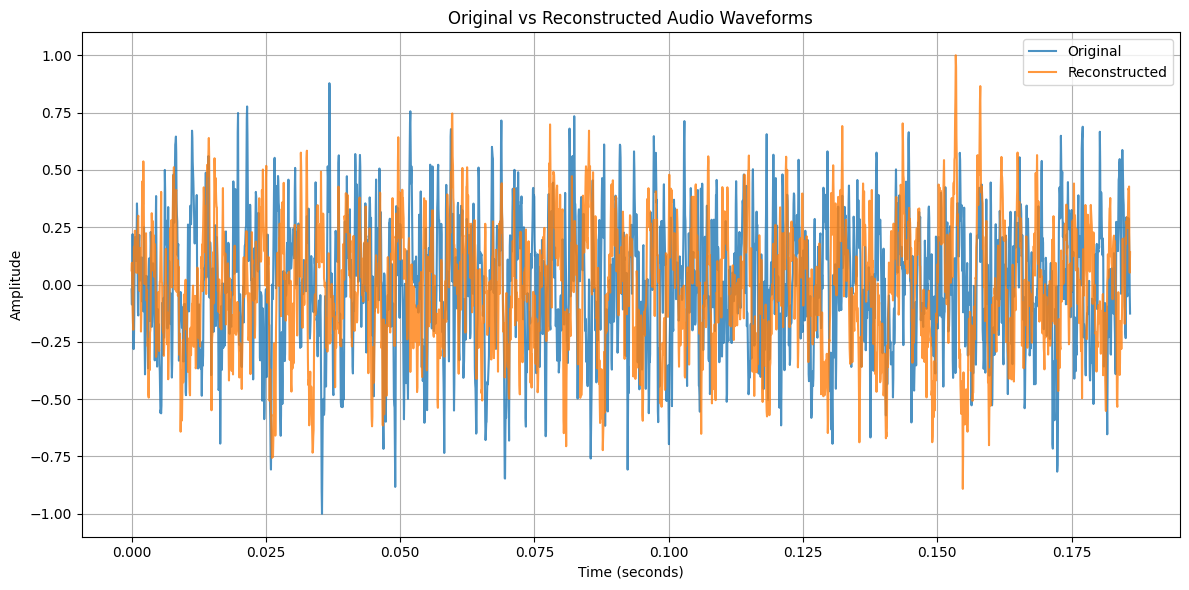

In [18]:
import os
import soundfile as sf
import matplotlib.pyplot as plt

# Directory to save audio files
output_dir = "audio_comparisons"
os.makedirs(output_dir, exist_ok=True)

# Load a sample batch from your DataLoader
audio_batch = next(iter(dataloader))
audio_batch = audio_batch.to(device)

# Reconstruct using the trained VAE
vae.eval()
recon_batch, _, _ = vae(audio_batch)

# Save and compare the original and reconstructed audio
sample_rate = 16000  # Same as used during preprocessing

# Save first sample from the batch
for i in range(1):  # Save only one pair for simplicity
    original = audio_batch[i].detach().cpu().numpy()
    reconstructed = recon_batch[i].detach().cpu().numpy()

    # Normalize for saving and playback
    original = original / (np.max(np.abs(original)) + 1e-8)
    reconstructed = reconstructed / (np.max(np.abs(reconstructed)) + 1e-8)

    # Save audio files
    sf.write(f"{output_dir}/original_{i}.wav", original, samplerate=sample_rate)
    sf.write(f"{output_dir}/reconstructed_{i}.wav", reconstructed, samplerate=sample_rate)

    print(f"Saved original and reconstructed audio to {output_dir}")

# Plot waveform comparison
plt.figure(figsize=(12, 6))
time = np.linspace(0, len(original) / sample_rate, len(original))

plt.plot(time, original, label="Original", alpha=0.8)
plt.plot(time, reconstructed, label="Reconstructed", alpha=0.8)
plt.title("Original vs Reconstructed Audio Waveforms")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [16]:
from IPython.display import Audio, display

# Play original
print("Original Audio:")
display(Audio(original, rate=sample_rate))

# Play reconstructed
print("Reconstructed Audio:")
display(Audio(reconstructed, rate=sample_rate))


Original Audio:


Reconstructed Audio:


In [10]:
# Load a sample batch
audio_batch = next(iter(dataloader))
audio_batch = audio_batch.to(device)

# Reconstruct using the VAE
vae.eval()
recon_batch, _, _ = vae(audio_batch)

# Save and compare the original and reconstructed audio
import soundfile as sf
import os

# Directory for saving samples
output_dir = "reconstructed_samples"
os.makedirs(output_dir, exist_ok=True)

# Target length for audio samples
target_length = 15000
sample_rate = 16000

for i in range(min(5, audio_batch.size(0))):  # Save a few samples
    original = audio_batch[i].detach().cpu().numpy()
    reconstructed = recon_batch[i].detach().cpu().numpy()

    # Ensure consistent length
    original = original[:target_length]
    reconstructed = reconstructed[:target_length]

    # Normalize for audio playback
    original = original / (np.max(np.abs(original)) + 1e-8)
    reconstructed = reconstructed / (np.max(np.abs(reconstructed)) + 1e-8)

    # Save original and reconstructed files
    sf.write(f"{output_dir}/original_{i}.wav", original, samplerate=sample_rate)
    sf.write(f"{output_dir}/reconstructed_{i}.wav", reconstructed, samplerate=sample_rate)

print(f"Saved original and reconstructed samples to {output_dir}")


Saved original and reconstructed samples to reconstructed_samples


In [9]:
torch.save(vae.state_dict(), 'vae_mel_spectrogram.pth')
# Load a sample batch
audio = next(iter(dataloader))
audio = audio.to(device)
recon, _, _ = vae(audio)
# Save reconstructed output
recon_audio = recon[0].detach().cpu().numpy()
sf.write('reconstructed.wav', recon_audio, samplerate=16000)


In [10]:
import soundfile as sf

# Save the reconstructed audio
recon_audio = recon[0].detach().cpu().numpy()

# Ensure the reconstructed audio has the correct shape
# Reshape if necessary (e.g., from [2974] to proper waveform format)
recon_audio = recon_audio.flatten()  # Ensure 1D array

# Normalize to [-1, 1] for valid audio
recon_audio = recon_audio / np.max(np.abs(recon_audio))

# Save as .wav file
sf.write('reconstructed.wav', recon_audio, samplerate=16000)
print("Reconstructed audio saved as 'reconstructed.wav'")


Reconstructed audio saved as 'reconstructed.wav'


C:\Users\Murad Hüseynov\AppData\Local\Temp\ipykernel_14580\1321650753.py:11: RuntimeWarning: divide by zero encountered in divide
  recon_audio = recon_audio / np.max(np.abs(recon_audio))
C:\Users\Murad Hüseynov\AppData\Local\Temp\ipykernel_14580\1321650753.py:11: RuntimeWarning: invalid value encountered in divide
  recon_audio = recon_audio / np.max(np.abs(recon_audio))


In [11]:
import IPython.display as ipd
ipd.Audio('reconstructed.wav')


In [12]:
print(f"Reconstructed audio shape: {recon_audio.shape}")
print(f"Reconstructed audio min: {recon_audio.min()}, max: {recon_audio.max()}")


Reconstructed audio shape: (2974,)
Reconstructed audio min: nan, max: nan


In [10]:
import os
from torch.utils.data import DataLoader

# Replace this with your audio folder path
audio_folder = 'ground_truth_others'

# Check if folder exists
if not os.path.exists(audio_folder):
    print(f"Folder not found: {audio_folder}")
else:
    print(f"Folder found: {audio_folder}")

# Check the number of .wav files in the folder
wav_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
print(f"Number of .wav files found in the folder: {len(wav_files)}")
print(f"First few files: {wav_files[:5]}")

# Instantiate the dataset
dataset = AudioDataset(audio_folder)

# Check dataset length
print(f"Dataset length: {len(dataset)}")

# Test fetching a single item
try:
    sample = dataset[0]
    print(f"Sample fetched successfully. Shape: {sample.shape}")
except Exception as e:
    print(f"Error fetching the first sample: {e}")

# Test the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
try:
    for batch_idx, batch in enumerate(dataloader):
        print(f"Batch {batch_idx} fetched successfully. Shape: {batch.shape}")
        if batch_idx == 2:  # Stop after a few batches to test
            break
except Exception as e:
    print(f"Error fetching batches: {e}")


Folder found: ground_truth_others
Number of .wav files found in the folder: 144
First few files: ['A Classic Education - NightOwl_other.wav', "Actions - Devil's Words_other.wav", 'Actions - One Minute Smile_other.wav', 'Actions - South Of The Water_other.wav', 'Aimee Norwich - Child_other.wav']
Dataset length: 144
Sample fetched successfully. Shape: torch.Size([2974])
Batch 0 fetched successfully. Shape: torch.Size([4, 2974])
Batch 1 fetched successfully. Shape: torch.Size([4, 2974])
Batch 2 fetched successfully. Shape: torch.Size([4, 2974])


In [34]:
import os
import torch
from torch.utils.data import DataLoader

# Define the audio folder
audio_folder = 'ground_truth_others_merged'  # Change to the path where your audio files are stored

# Initialize the AudioDataset
dataset = AudioDataset(audio_folder=audio_folder)

# Test the _getitem_ method
for idx in range(min(5, len(dataset))):  # Test on the first 5 items or fewer
    print(f"\nTesting dataset item at index {idx}")
    processed_audio = dataset[idx]  # Call _getitem_
    print(f"Processed audio shape: {processed_audio.shape}")
    print(f"Processed audio type: {type(processed_audio)}")
    print(f"Processed audio dtype: {processed_audio.dtype}")


Testing dataset item at index 0
Loaded audio from ground_truth_others_merged\A Classic Education - NightOwl_other.wav with shape: torch.Size([2, 300032])
Processed audio shape: torch.Size([2, 300032])
Processed audio type: <class 'torch.Tensor'>
Processed audio dtype: torch.float32

Testing dataset item at index 1
Loaded audio from ground_truth_others_merged\Actions - Devil's Words_other.wav with shape: torch.Size([2, 300032])
Processed audio shape: torch.Size([2, 300032])
Processed audio type: <class 'torch.Tensor'>
Processed audio dtype: torch.float32

Testing dataset item at index 2
Loaded audio from ground_truth_others_merged\Actions - One Minute Smile_other.wav with shape: torch.Size([2, 300032])
Processed audio shape: torch.Size([2, 300032])
Processed audio type: <class 'torch.Tensor'>
Processed audio dtype: torch.float32

Testing dataset item at index 3
Loaded audio from ground_truth_others_merged\Actions - South Of The Water_other.wav with shape: torch.Size([2, 300032])
Proces